In [ ]:
import numpy as np
import pandas as pd

import torch
from torch.optim import Adam
from torch.nn import Linear
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns
import imageio
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings

warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

np.random.seed(45)
torch.manual_seed(45)

## Task 1
Ascending the Gradient Descent [6 marks]

1. Use ```torch.autograd``` to find the true gradient on the above dataset using linear regression (in the form $\theta_1x + \theta_0$) for any given values of $(\theta_0,\theta_1)$. **[1 mark]**

In [ ]:
np.random.seed(45)
num_samples = 40

# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = torch.tensor(f_x + eps)

In [ ]:
theta_0 = torch.empty(1, requires_grad=True, device=device, dtype=torch.float32)
theta_1 = torch.empty(1, requires_grad=True, device=device, dtype=torch.float32)

torch.nn.init.uniform_(theta_0, a=-0.1, b=0.1)
torch.nn.init.uniform_(theta_1, a=-0.1, b=0.1)

tensor([0.0923], requires_grad=True)

In [ ]:
def model(x):

    y_pred = theta_0 + theta_1*x
    return y_pred

In [ ]:
x1 = torch.tensor(x1, device=device)

optimizer = Adam([theta_0, theta_1], lr=0.01)

loss_fn = torch.nn.MSELoss()
loss = loss_fn(y, model(x1))

loss.backward()

print(f"True grad of theta_0 is {theta_0.grad.item()}")
print(f"True grad of theta_1 is {theta_1.grad.item()}")

True grad of theta_0 is -7.587903022766113
True grad of theta_1 is -0.9564138650894165


2. Using the same $(\theta_0,\theta_1)$ as above, calculate the stochastic gradient for all points in the dataset. Then, find the average of all those gradients and show that the stochastic gradient is a good estimate of the true gradient.  **[1 mark]**


In [ ]:
loss_fn = torch.nn.MSELoss()

loss = []

for i in range(len(y)):

    loss.append(loss_fn(y[i], model(x1[0])))

loss = torch.tensor(loss, requires_grad=True).mean()

loss.backward()

print(f"True grad of theta_0 is {theta_0.grad.item()}")
print(f"True grad of theta_1 is {theta_1.grad.item()}")

True grad of theta_0 is -7.587903022766113
True grad of theta_1 is -0.9564138650894165


We can see the gradient of parameter after both gradient descent and stochastic gradient are same hence we can say that the stochastic gradient is a good estimate of the true gradient.

3. Implement full-batch, mini-batch and stochastic gradient descent. Calculate the average number of iterations required for each method to get sufficiently close to the optimal solution, where "sufficiently close" means within a distance of $\epsilon$ (or $\epsilon$-neighborhood)  from the minimum value of the loss function. Visualize the convergence process for 15 epochs. Choose $\epsilon = 0.001$ for convergence criteria. Which optimization process takes a larger number of epochs to converge, and why? Show the contour plots for different epochs (or show an animation/GIF) for visualisation of optimisation process. Also, make a plot for Loss v/s epochs for all the methods. **[2 marks]**

full batch

In [ ]:
theta_0_full_batch = theta_0.clone().detach().requires_grad_(True)
theta_1_full_batch = theta_1.clone().detach().requires_grad_(True)

def model(x):

    y_pred = theta_0_full_batch + theta_1_full_batch*x
    return y_pred
lr = 0.001

loss_fn = torch.nn.MSELoss()
gd_loss = []
gd_theta_0_values = []
gd_theta_1_values = []

for epoch in range(10000):

    loss = loss_fn(y, model(x1))

    loss.backward()

    with torch.no_grad():
        theta_0_full_batch -= lr*theta_0_full_batch.grad
        theta_1_full_batch -= lr*theta_1_full_batch.grad

    theta_0_full_batch.grad.zero_()
    theta_1_full_batch.grad.zero_()

    if epoch%500 == 0:
        print(f"Epoch: {epoch} -> Loss: {loss}")
    gd_loss.append(loss.detach().numpy())
    gd_theta_0_values.append(theta_0_full_batch.item())
    gd_theta_1_values.append(theta_1_full_batch.item())



Epoch: 0 -> Loss: 17.060736913452303
Epoch: 500 -> Loss: 3.945730428162382
Epoch: 1000 -> Loss: 1.6748144684668063
Epoch: 1500 -> Loss: 1.0835894631130976
Epoch: 2000 -> Loss: 0.8475646794083957
Epoch: 2500 -> Loss: 0.7306990523174648
Epoch: 3000 -> Loss: 0.6687611758610755
Epoch: 3500 -> Loss: 0.6353445734058891
Epoch: 4000 -> Loss: 0.6172352770648786
Epoch: 4500 -> Loss: 0.6074113524903912
Epoch: 5000 -> Loss: 0.6020803946741762
Epoch: 5500 -> Loss: 0.5991874243478406
Epoch: 6000 -> Loss: 0.5976173812184636
Epoch: 6500 -> Loss: 0.5967653282032581
Epoch: 7000 -> Loss: 0.5963029141036992
Epoch: 7500 -> Loss: 0.5960519634510437
Epoch: 8000 -> Loss: 0.5959157718312408
Epoch: 8500 -> Loss: 0.5958418779165171
Epoch: 9000 -> Loss: 0.595801771529046
Epoch: 9500 -> Loss: 0.5957800025066632


Mini batch

In [ ]:
theta_0_mini_batch = theta_0.clone().detach().requires_grad_(True)
theta_1_mini_batch = theta_1.clone().detach().requires_grad_(True)

x1 = x1.to(dtype=torch.float32)
y = y.to(dtype=torch.float32)

def model(x):

    y_pred = theta_0_mini_batch + theta_1_mini_batch*x
    return y_pred

loss_fn = torch.nn.MSELoss()

mini_batch_loss = []
mini_theta_0_values = []
mini_theta_1_values = []
lr=0.001

batch_size = 10

for epoch in range(2400):

    loss_epoch = 0

    for i in range(len(y)//batch_size):

        loss = loss_fn(y[i*batch_size: (i+1)*batch_size], model(x1[i*batch_size: (i+1)*batch_size]))
        loss_epoch += loss.item()*batch_size

        loss.backward()

        with torch.no_grad():
            theta_0_mini_batch -= lr*theta_0_mini_batch.grad
            theta_1_mini_batch -= lr*theta_1_mini_batch.grad

        theta_0_mini_batch.grad.zero_()
        theta_1_mini_batch.grad.zero_()



    mean_loss = loss_epoch/len(y)
    if epoch%200 == 0:
        print(f"Epoch: {epoch} -> Loss: {mean_loss}")
    mini_batch_loss.append(mean_loss)
    mini_theta_0_values.append(theta_0_mini_batch.item())
    mini_theta_1_values.append(theta_1_mini_batch.item())

Epoch: 0 -> Loss: 16.974835872650146
Epoch: 200 -> Loss: 2.199231833219528
Epoch: 400 -> Loss: 1.0197742283344269
Epoch: 600 -> Loss: 0.7482557743787766
Epoch: 800 -> Loss: 0.6529111787676811
Epoch: 1000 -> Loss: 0.6173235103487968
Epoch: 1200 -> Loss: 0.6039518117904663
Epoch: 1400 -> Loss: 0.5989241525530815
Epoch: 1600 -> Loss: 0.5970336943864822
Epoch: 1800 -> Loss: 0.5963228642940521
Epoch: 2000 -> Loss: 0.5960555225610733
Epoch: 2200 -> Loss: 0.5959552302956581


stochastic gradient

In [ ]:
theta_0_stochastic = theta_0.clone().detach().requires_grad_(True)
theta_1_stochastic = theta_1.clone().detach().requires_grad_(True)

x1 = x1.to(dtype=torch.float32)
y = y.to(dtype=torch.float32)

def model(x):

    y_pred = theta_0_stochastic + theta_1_stochastic*x
    return y_pred

loss_fn = torch.nn.MSELoss()

stochastic_loss = []
stochastic_theta_0_values = []
stochastic_theta_1_values = []

lr=0.001

for epoch in range(500):

    loss_ = []

    for iter in range(len(y)):

        loss = loss_fn(y[iter], model(x1[iter]))
        loss_.append(loss)

        loss.backward()

        with torch.no_grad():
            theta_0_stochastic -= lr*theta_0_stochastic.grad
            theta_1_stochastic -= lr*theta_1_stochastic.grad

        theta_0_stochastic.grad.zero_()
        theta_1_stochastic.grad.zero_()

    mean_loss = torch.tensor(loss_).mean()
    if epoch%50 == 0:
        print(f"Epoch: {epoch} -> Loss: {mean_loss}")

    stochastic_loss.append(mean_loss.item())
    stochastic_theta_0_values.append(theta_0_stochastic.item())
    stochastic_theta_1_values.append(theta_1_stochastic.item())

Epoch: 0 -> Loss: 15.991795539855957
Epoch: 50 -> Loss: 0.8417197465896606
Epoch: 100 -> Loss: 0.618023157119751
Epoch: 150 -> Loss: 0.5990787744522095
Epoch: 200 -> Loss: 0.5974621176719666
Epoch: 250 -> Loss: 0.5973285436630249
Epoch: 300 -> Loss: 0.5973188281059265
Epoch: 350 -> Loss: 0.5973185896873474
Epoch: 400 -> Loss: 0.5973187685012817
Epoch: 450 -> Loss: 0.5973187685012817


Full Batch Gradient took 6500 epochs to converge

Mini Batch Gradient took 2000 epochs to converge

stochastic Gradient took 250 epochs to converge

Visualization of loss

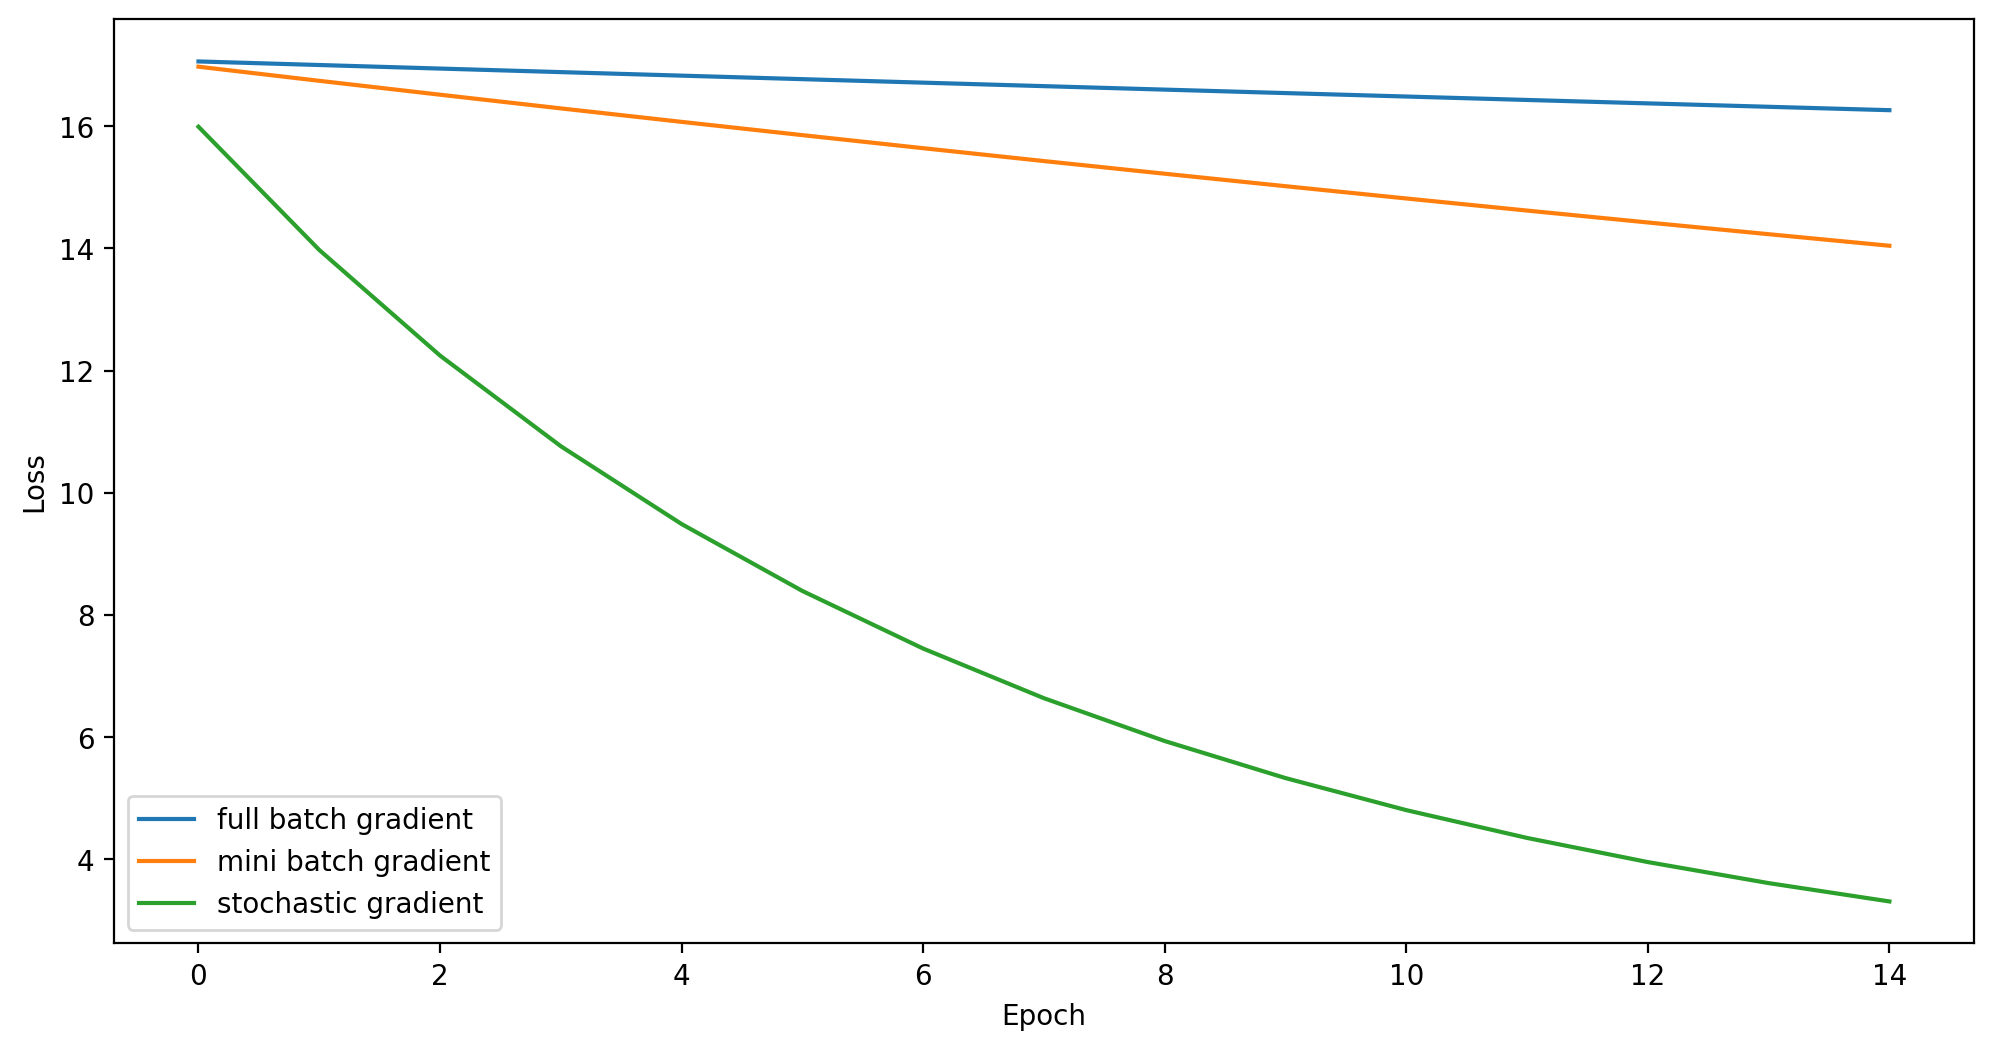

In [ ]:
fig, ax = plt.subplots(1, 1,  figsize=(12,6))

ax.plot(gd_loss[:15], label="full batch gradient")
ax.plot(mini_batch_loss[:15], label="mini batch gradient")
ax.plot(stochastic_loss[:15], label="stochastic gradient")

plt.xlabel('Epoch')
plt.ylabel('Loss')

ax.legend()
plt.show()

Full batch gradient descent took large number of epochs to converge because in gradient descent the gradient is calculated as an average on all training example which provides a very accurate estimate of the gradient but it also make very small updates where as stochastic gradient descent calculate gradient for each training example due to which it makes frequent updates and hence converge faster.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_loss_grid(theta_0_range, theta_1_range, x1, y, loss_fn):
    grid_loss = np.zeros((len(theta_0_range), len(theta_1_range)))
    gradient_theta_0 = np.zeros((len(theta_0_range), len(theta_1_range)))
    gradient_theta_1 = np.zeros((len(theta_0_range), len(theta_1_range)))

    for i, theta_0 in enumerate(theta_0_range):
        for j, theta_1 in enumerate(theta_1_range):
            theta_0_stochastic = torch.tensor(theta_0, dtype=torch.float32, requires_grad=True)
            theta_1_stochastic = torch.tensor(theta_1, dtype=torch.float32, requires_grad=True)

            model = lambda x: theta_0_stochastic + theta_1_stochastic * x
            loss = torch.tensor(0.0)
            for k in range(len(y)):
                loss += loss_fn(y[k], model(x1[k]))

            loss.backward()

            grid_loss[i, j] = loss.item() / len(y)
            gradient_theta_0[i, j] = theta_0_stochastic.grad.item()
            gradient_theta_1[i, j] = theta_1_stochastic.grad.item()

            theta_0_stochastic.grad.zero_()
            theta_1_stochastic.grad.zero_()

    return grid_loss, gradient_theta_0, gradient_theta_1

theta_0_range = np.linspace(-1.5, 6, 100)
theta_1_range = np.linspace(-1.6, 6, 100)

grid_loss, gradient_theta_0, gradient_theta_1 = evaluate_loss_grid(theta_0_range, theta_1_range, x1, y, loss_fn)

subsample_ratio = 0.1
total_points = len(theta_0_range)
subsample_size = int(total_points**2 * subsample_ratio)
indices = np.random.choice(total_points**2, subsample_size, replace=False)

X_flat = np.linspace(theta_0_range[0], theta_0_range[-1], total_points)
Y_flat = np.linspace(theta_1_range[0], theta_1_range[-1], total_points)
X_flat, Y_flat = np.meshgrid(X_flat, Y_flat)
X_flat = X_flat.flatten()
Y_flat = Y_flat.flatten()
U_flat = gradient_theta_0.flatten()
V_flat = gradient_theta_1.flatten()

X_subsampled = X_flat[indices]
Y_subsampled = Y_flat[indices]
U_subsampled = U_flat[indices]
V_subsampled = V_flat[indices]

speed = np.sqrt(U_subsampled**2 + V_subsampled**2)
U_normalized = U_subsampled / speed
V_normalized = V_subsampled / speed


In [ ]:
def create_contour_plot(epoch, theta_0_range, theta_1_range, grid_loss,
                         theta_0, theta_1, prev_theta_0, prev_theta_1):

    plt.figure(figsize=(8, 6))

    plt.scatter(theta_0, theta_1, color='white', edgecolor='black', s=30, zorder=5)
    plt.contourf(theta_0_range, theta_1_range, grid_loss.T, cmap='viridis')
    plt.plot(prev_theta_0, prev_theta_1, color='r')

    plt.colorbar(label='Loss')
    plt.title(f'Contour Plot of Loss at Epoch {epoch}')
    plt.xlabel('Theta 0')
    plt.ylabel('Theta 1')

    plt.grid(True)
    plt.savefig(f'./contour_plot/epoch_{epoch}.png')
    plt.close()

for epoch in range(0, 7000, 50):

    create_contour_plot(epoch, theta_0_range, theta_1_range,
                         grid_loss, gd_theta_0_values[epoch],
                         gd_theta_1_values[epoch],
                         gd_theta_0_values[:epoch],
                         gd_theta_1_values[:epoch])


In [ ]:
def create_gif():
    images = []
    for epoch in range(0, 7000, 50):
        filename = f'./contour_plot/epoch_{epoch}.png'
        images.append(imageio.imread(filename))
    imageio.mimsave('contour_plot.gif', images, duration=0.5)

create_gif()

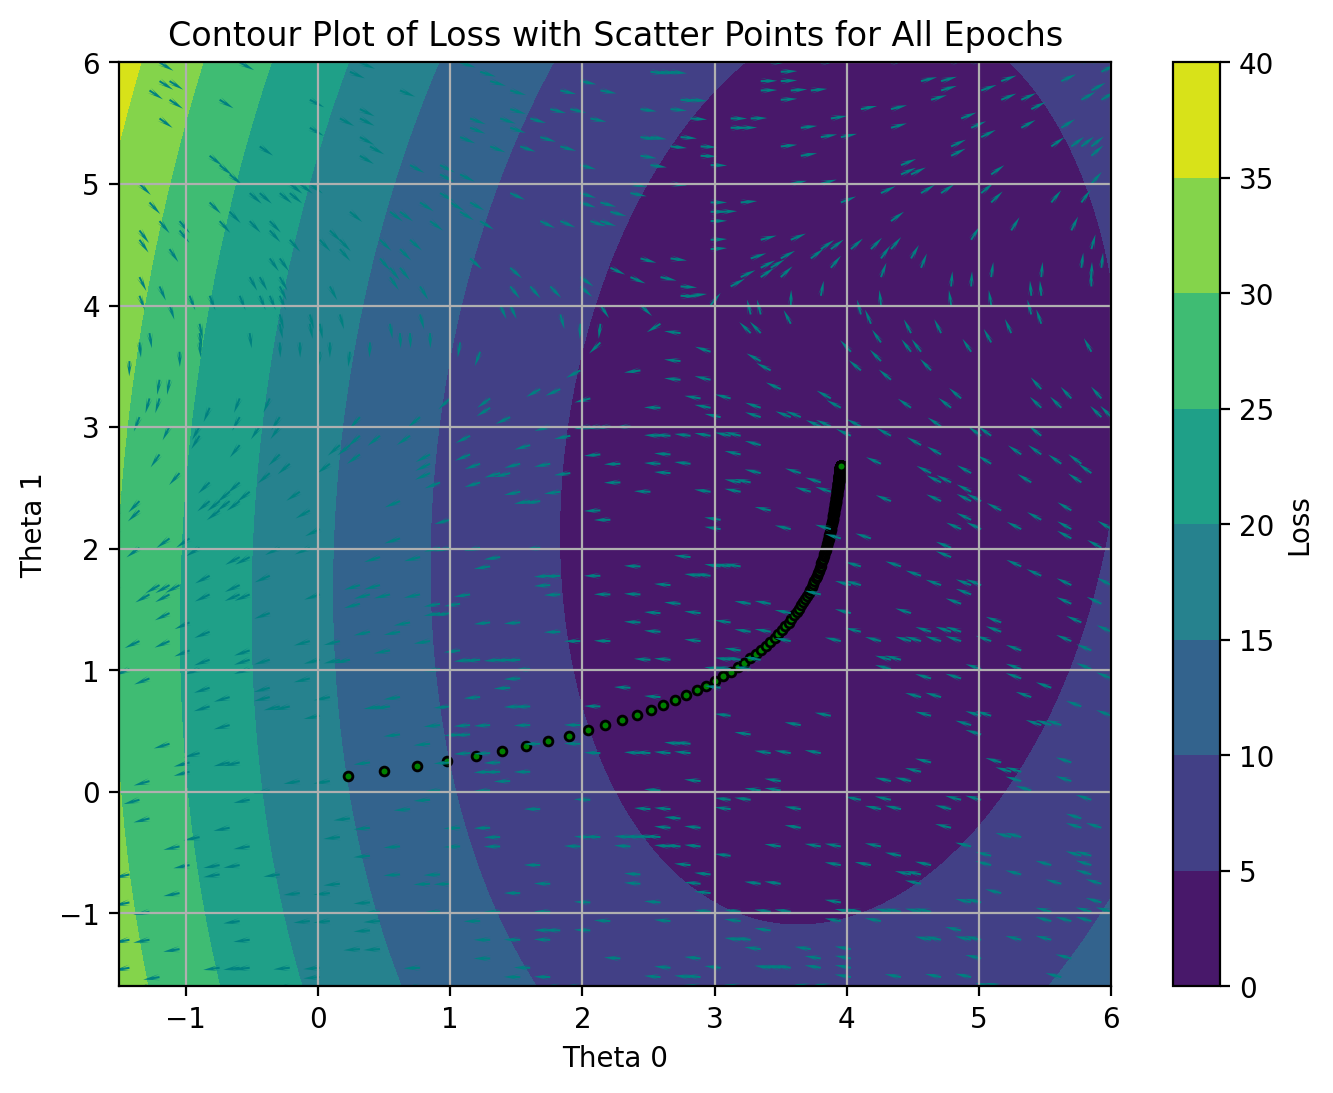

In [ ]:
plt.figure(figsize=(8, 6))

plt.contourf(theta_0_range, theta_1_range, grid_loss.T, s = 50, cmap='viridis')
plt.colorbar(label='Loss')

#plt.scatter(gd_theta_0_values, gd_theta_1_values, color='blue', edgecolor='black', s=10)
#plt.scatter(mini_theta_0_values, mini_theta_1_values, color='red', edgecolor='black', s=10)
plt.scatter(stochastic_theta_0_values, stochastic_theta_1_values, color='green',
             edgecolor='black', s=10)
plt.quiver(X_subsampled, Y_subsampled, U_normalized, V_normalized,
           color='Teal', headlength=8, scale=8, scale_units='xy', width=0.005)



plt.title('Contour Plot of Loss with Scatter Points for All Epochs')
plt.xlabel('Theta 0')
plt.ylabel('Theta 1')
plt.grid(True)

plt.show()

4. Explore the article [here](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/#:~:text=Momentum%20is%20an%20extension%20to,spots%20of%20the%20search%20space.) on gradient descent with momentum. Implement gradient descent with momentum for the dataset. Visualize the convergence process for 15 steps. Compare the average number of steps taken with gradient descent (for variants full batch and stochastic) with momentum to that of vanilla gradient descent to converge to an $\epsilon$-neighborhood for both dataset. Choose $\epsilon = 0.001$. Write down your observations. Show the contour plots for different epochs for momentum implementation. Specifically, show all the vectors: gradient, current value of theta, momentum, etc. **[2 marks]**

full batch

In [ ]:
theta_0_full_batch_with_momentum = theta_0.clone().detach().requires_grad_(True)
theta_1_full_batch_with_momentum = theta_1.clone().detach().requires_grad_(True)

def model(x):

    y_pred = theta_0_full_batch_with_momentum + theta_1_full_batch_with_momentum*x
    return y_pred

lr = 0.001
gm = 0.9
prev_update_theta_0 = 0
prev_update_theta_1 = 0

loss_fn = torch.nn.MSELoss()
gd_with_momentum_loss = []
momentum_gd_theta_0_values = []
momentum_gd_theta_1_values = []


for epoch in range(7001):

    loss = loss_fn(y, model(x1))

    loss.backward()

    old_theta_0_full_batch_with_momentum = theta_0_full_batch_with_momentum.clone()
    old_theta_1_full_batch_with_momentum = theta_1_full_batch_with_momentum.clone()

    with torch.no_grad():

        v_theta_0 = lr*theta_0_full_batch_with_momentum.grad + gm*prev_update_theta_0
        v_theta_1 = lr*theta_1_full_batch_with_momentum.grad + gm*prev_update_theta_1

        theta_0_full_batch_with_momentum -= v_theta_0
        theta_1_full_batch_with_momentum -= v_theta_1

        prev_update_theta_0 = v_theta_0
        prev_update_theta_1 = v_theta_1

    theta_0_full_batch_with_momentum.grad.zero_()
    theta_1_full_batch_with_momentum.grad.zero_()

    if epoch%500 == 0:
        print(f"Epoch: {epoch} -> Loss: {loss}")
    gd_with_momentum_loss.append(loss.detach().numpy())
    momentum_gd_theta_0_values.append(theta_0_full_batch_with_momentum.item())
    momentum_gd_theta_1_values.append(theta_0_full_batch_with_momentum.item())

Epoch: 0 -> Loss: 17.06073760986328
Epoch: 500 -> Loss: 0.6005775928497314
Epoch: 1000 -> Loss: 0.5957612991333008
Epoch: 1500 -> Loss: 0.5957542061805725
Epoch: 2000 -> Loss: 0.5957542657852173
Epoch: 2500 -> Loss: 0.5957542657852173
Epoch: 3000 -> Loss: 0.5957542657852173
Epoch: 3500 -> Loss: 0.5957542657852173
Epoch: 4000 -> Loss: 0.5957542657852173
Epoch: 4500 -> Loss: 0.5957542657852173
Epoch: 5000 -> Loss: 0.5957542657852173
Epoch: 5500 -> Loss: 0.5957542657852173
Epoch: 6000 -> Loss: 0.5957542657852173
Epoch: 6500 -> Loss: 0.5957542657852173
Epoch: 7000 -> Loss: 0.5957542657852173


GD with momentum is taking around 1000 epochs to converge with loss 0.5957 while GD without momentum took around 10000 epochs to converge with loss 0.5957

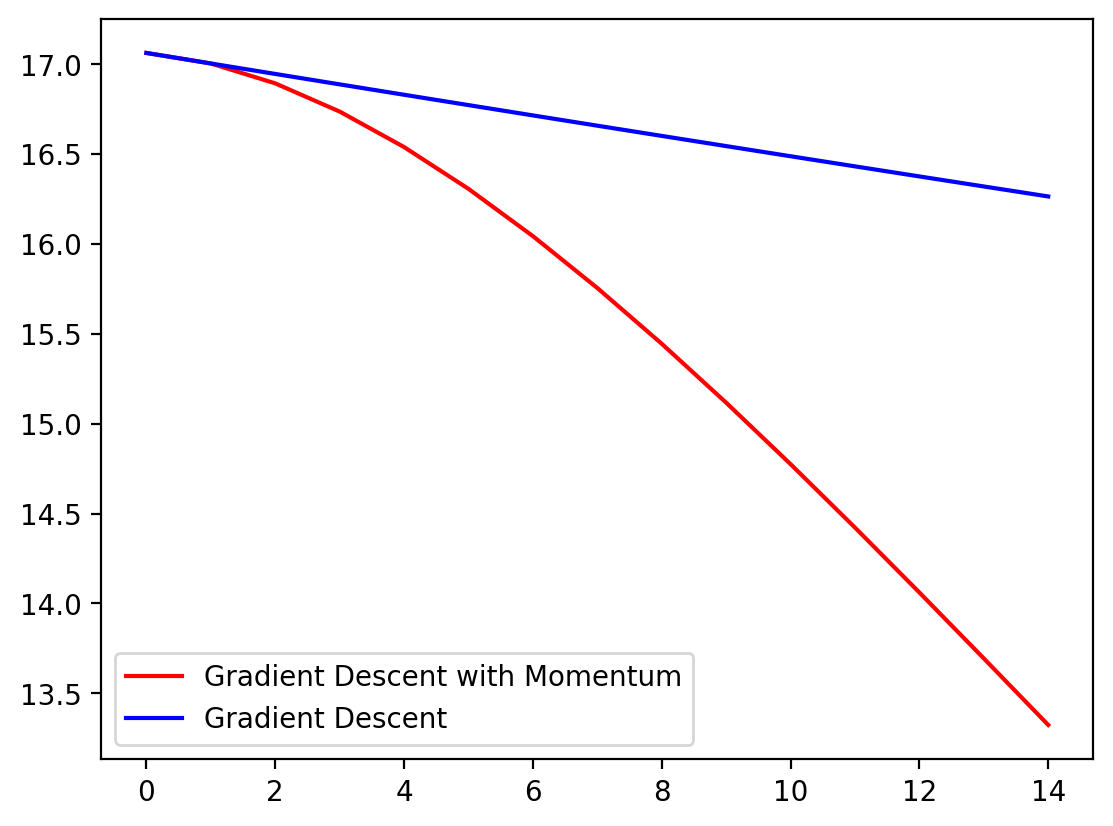

In [ ]:
plt.plot(gd_with_momentum_loss[:15], color='r', label="Gradient Descent with Momentum")
plt.plot(gd_loss[:15], color='b', label="Gradient Descent")
plt.legend()
plt.show()

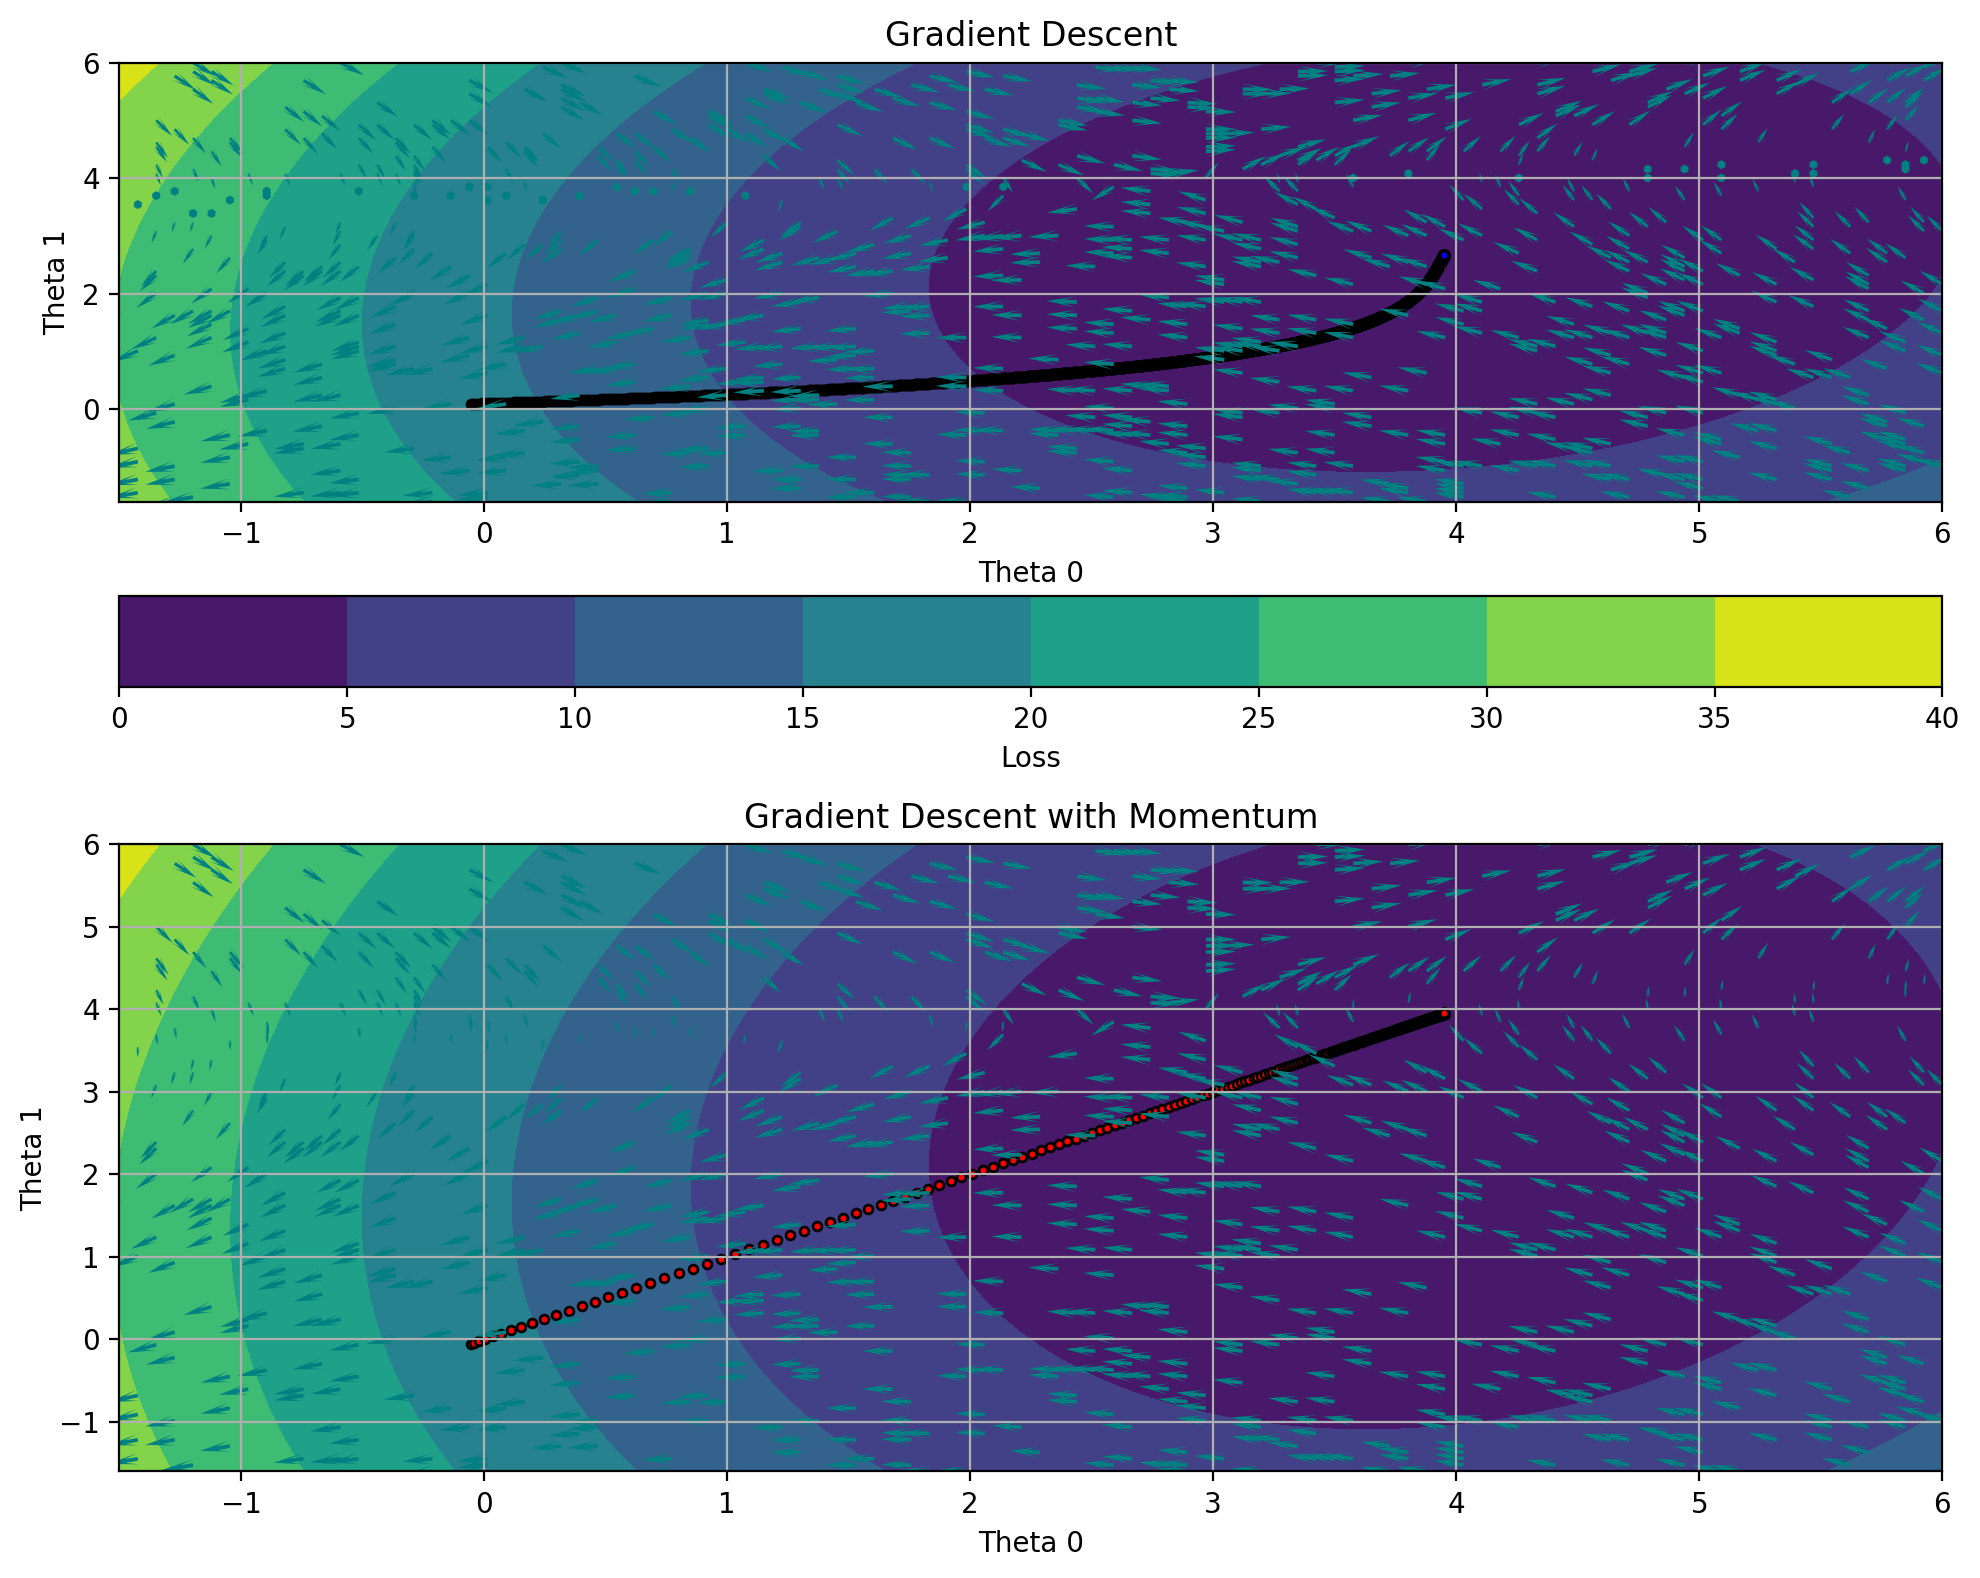

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

contour1 = axs[0].contourf(theta_0_range, theta_1_range, grid_loss.T, s=50, cmap='viridis')
axs[0].scatter(gd_theta_0_values, gd_theta_1_values, color='blue',
               edgecolor='black', s=10)
axs[0].quiver(X_subsampled, Y_subsampled, U_normalized, V_normalized,
           color='Teal', headlength=8, scale=8, scale_units='xy', width=0.005)

axs[0].set_title('Gradient Descent')
axs[0].set_xlabel('Theta 0')
axs[0].set_ylabel('Theta 1')
axs[0].grid(True)

contour2 = axs[1].contourf(theta_0_range, theta_1_range, grid_loss.T, s=50, cmap='viridis')
axs[1].scatter(momentum_gd_theta_0_values, momentum_gd_theta_0_values, color='red',
               edgecolor='black', s=10)
axs[1].quiver(X_subsampled, Y_subsampled, U_normalized, V_normalized,
           color='Teal', headlength=8, scale=8, scale_units='xy', width=0.005)

axs[1].set_title('Gradient Descent with Momentum')
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].grid(True)

fig.colorbar(contour1, orientation='horizontal', label='Loss')

plt.tight_layout()
plt.show()


mini batch

In [ ]:
theta_0_mini_batch_momentum = theta_0.clone().detach().requires_grad_(True)
theta_1_mini_batch_momentum = theta_1.clone().detach().requires_grad_(True)

x1 = x1.to(dtype=torch.float32)
y = y.to(dtype=torch.float32)

def model(x):

    y_pred = theta_0_mini_batch_momentum + theta_1_mini_batch_momentum*x
    return y_pred

loss_fn = torch.nn.MSELoss()

prev_update_theta_0 = 0
prev_update_theta_1 = 0

momentum_mini_batch_loss = []
momentum_mini_theta_0_values = []
momentum_mini_theta_1_values = []

lr=0.001
gm = 0.9
batch_size = 10

for epoch in range(2400):

    loss_epoch = 0

    for i in range(len(y)//batch_size):

        old_theta_0_mini_batch_with_momentum = theta_0_mini_batch_momentum.clone()
        old_theta_1_mini_batch_with_momentum = theta_1_mini_batch_momentum.clone()


        loss = loss_fn(y[i*batch_size: (i+1)*batch_size], model(x1[i*batch_size: (i+1)*batch_size]))
        loss_epoch += loss.item()*batch_size

        loss.backward()

        with torch.no_grad():

            v_theta_0 = lr*theta_0_mini_batch_momentum.grad + gm*prev_update_theta_0
            v_theta_1 = lr*theta_1_mini_batch_momentum.grad + gm*prev_update_theta_1

            theta_0_mini_batch_momentum -= v_theta_0
            theta_1_mini_batch_momentum -= v_theta_1

            prev_update_theta_0 = v_theta_0
            prev_update_theta_1 = v_theta_1

        theta_0_mini_batch_momentum.grad.zero_()
        theta_1_mini_batch_momentum.grad.zero_()



    mean_loss = loss_epoch/len(y)
    if epoch%200 == 0:
        print(f"Epoch: {epoch} -> Loss: {mean_loss}")
    momentum_mini_batch_loss.append(mean_loss)
    momentum_mini_theta_0_values.append(theta_0_mini_batch_momentum.item())
    momentum_mini_theta_1_values.append(theta_1_mini_batch_momentum.item())

Epoch: 0 -> Loss: 16.925453662872314
Epoch: 200 -> Loss: 0.5959760919213295
Epoch: 400 -> Loss: 0.5958833992481232
Epoch: 600 -> Loss: 0.5958834961056709
Epoch: 800 -> Loss: 0.5958834961056709
Epoch: 1000 -> Loss: 0.5958834961056709
Epoch: 1200 -> Loss: 0.5958834961056709
Epoch: 1400 -> Loss: 0.5958834961056709
Epoch: 1600 -> Loss: 0.5958834961056709
Epoch: 1800 -> Loss: 0.5958834961056709
Epoch: 2000 -> Loss: 0.5958834961056709
Epoch: 2200 -> Loss: 0.5958834961056709


Mini batch GD with momentum is taking around 400 epochs to converge with loss 0.5958 while Mini batch GD without momentum took around 2000 epochs to converge with loss 0.5959

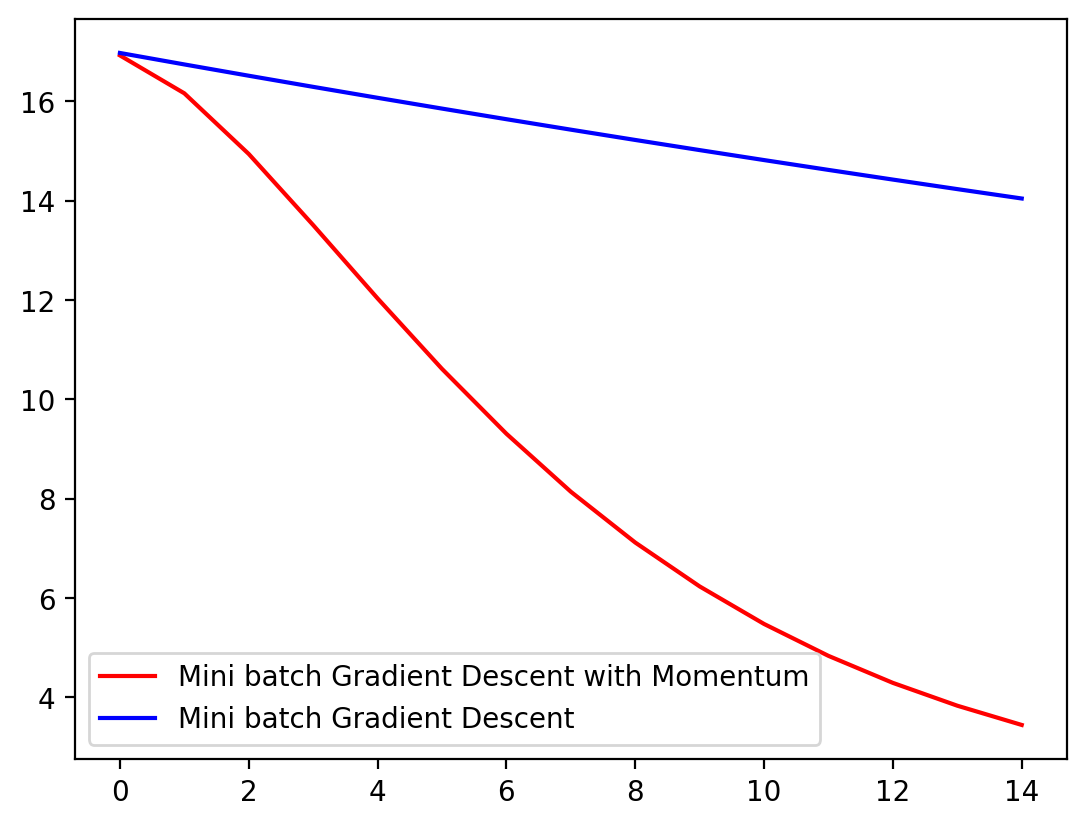

In [ ]:
plt.plot(momentum_mini_batch_loss[:15], color='r', label='Mini batch Gradient Descent with Momentum')
plt.plot(mini_batch_loss[:15], color='b', label='Mini batch Gradient Descent')
plt.legend()
plt.show()

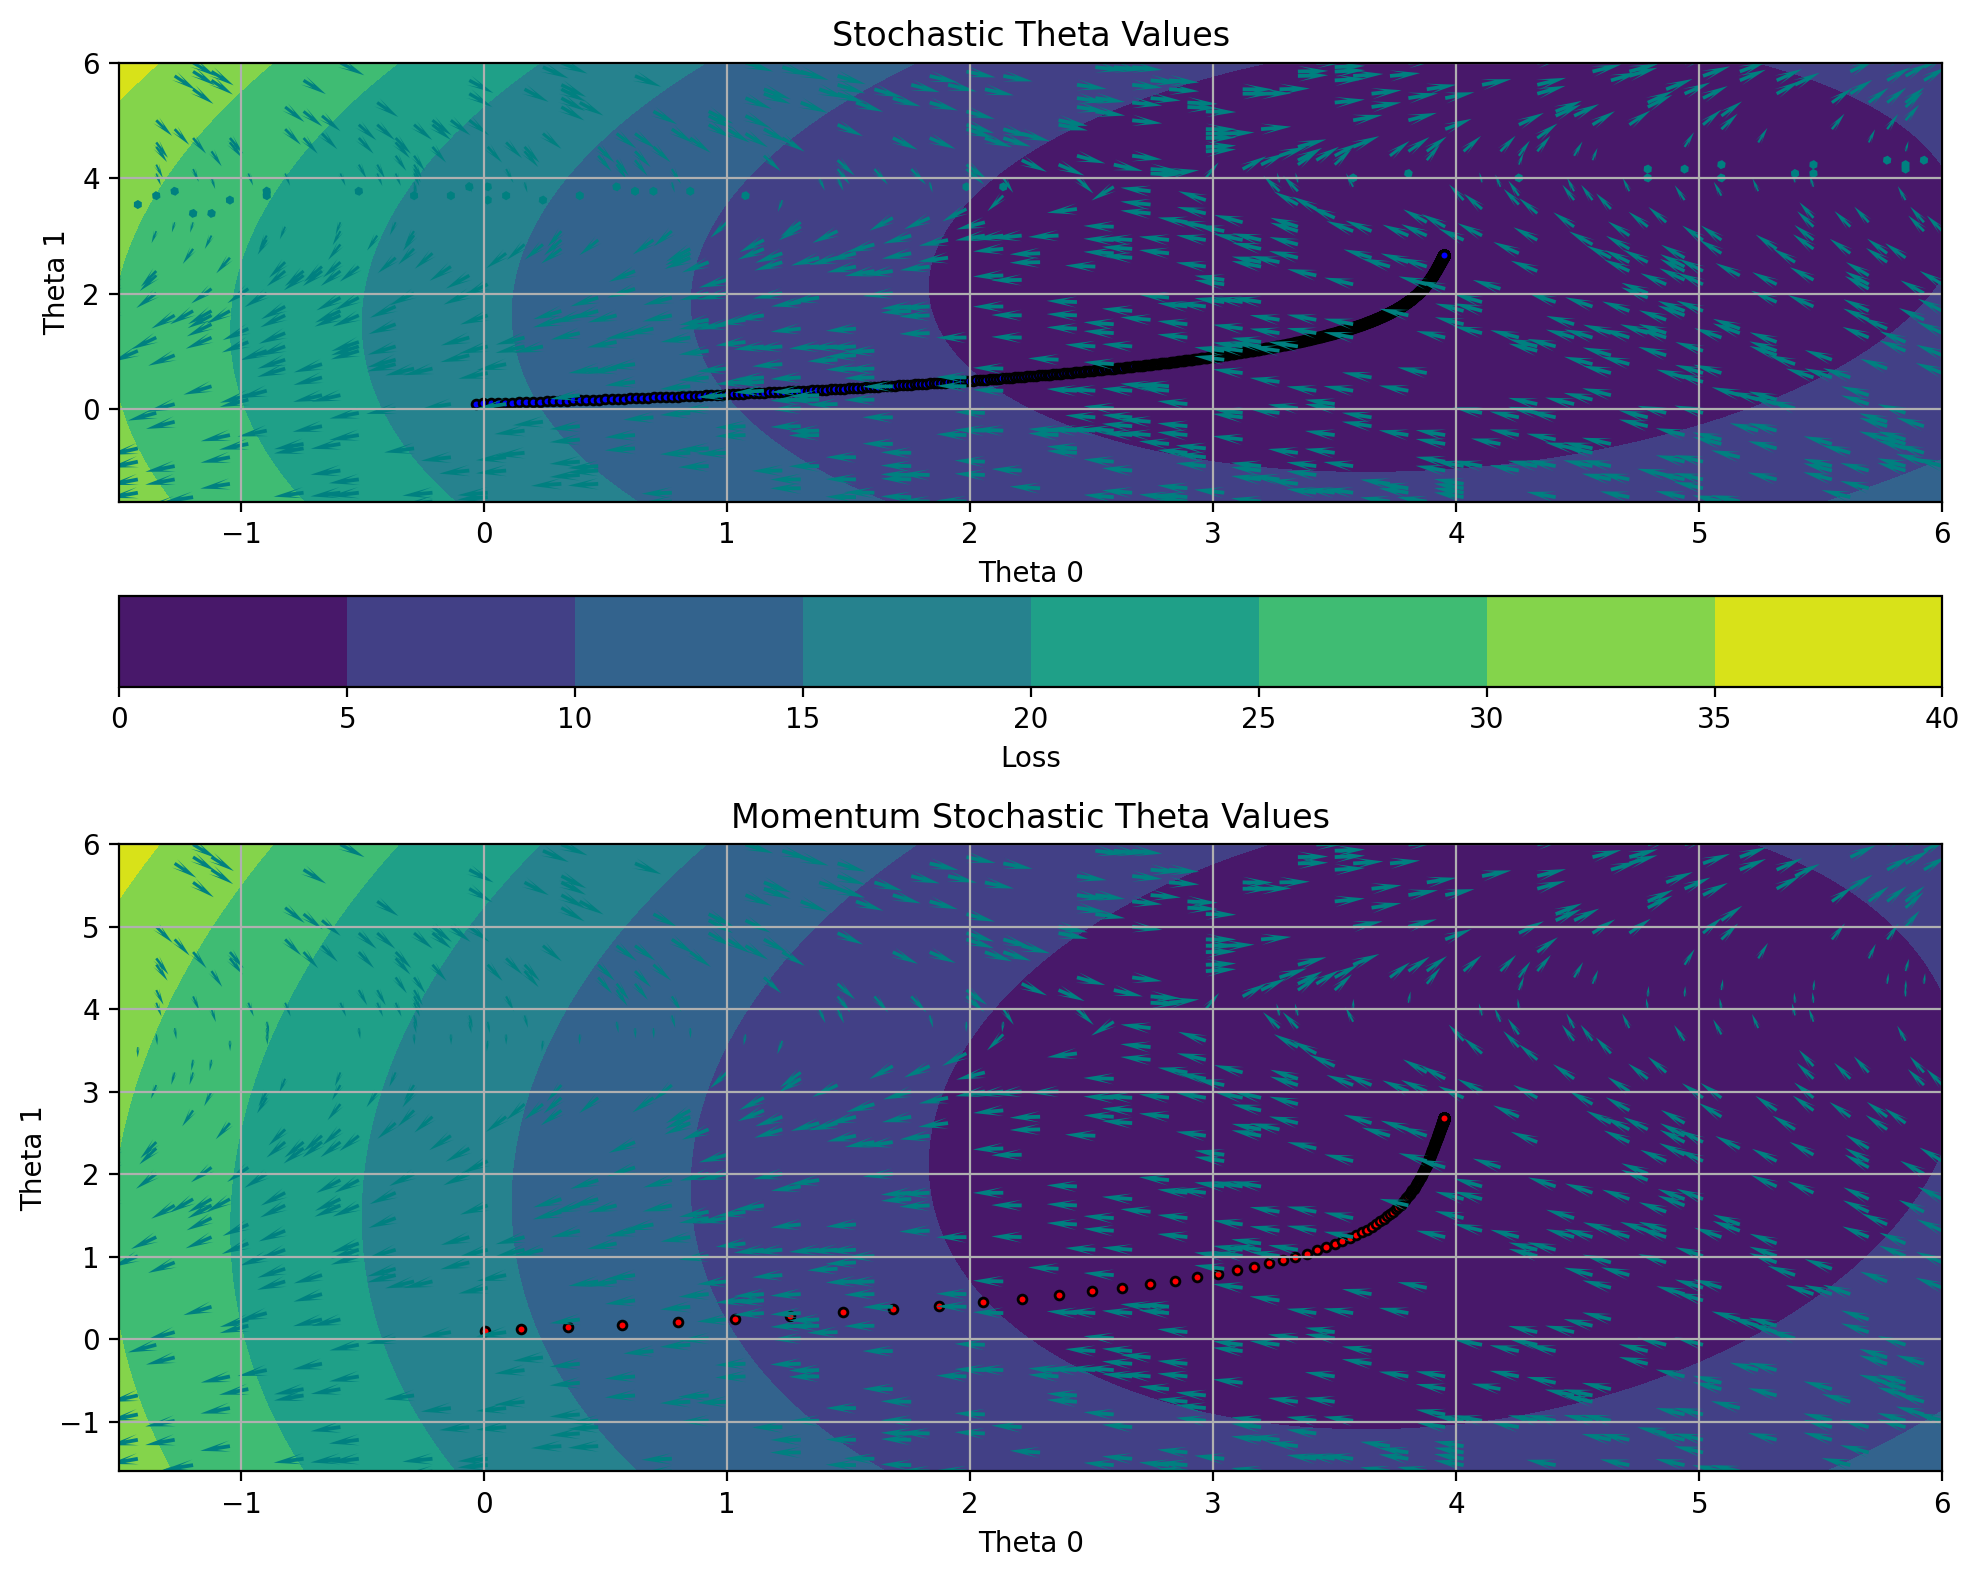

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

contour1 = axs[0].contourf(theta_0_range, theta_1_range, grid_loss.T, s=50, cmap='viridis')
axs[0].scatter(mini_theta_0_values, mini_theta_1_values, color='blue',
               edgecolor='black', s=10)
axs[0].quiver(X_subsampled, Y_subsampled, U_normalized, V_normalized,
           color='Teal', headlength=8, scale=8, scale_units='xy', width=0.005)

axs[0].set_title('Stochastic Theta Values')
axs[0].set_xlabel('Theta 0')
axs[0].set_ylabel('Theta 1')
axs[0].grid(True)

contour2 = axs[1].contourf(theta_0_range, theta_1_range, grid_loss.T, s=50, cmap='viridis')
axs[1].scatter(momentum_mini_theta_0_values, momentum_mini_theta_1_values, color='red',
               edgecolor='black', s=10)
axs[1].quiver(X_subsampled, Y_subsampled, U_normalized, V_normalized,
           color='Teal', headlength=8, scale=8, scale_units='xy', width=0.005)

axs[1].set_title('Momentum Stochastic Theta Values')
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].grid(True)

fig.colorbar(contour1, orientation='horizontal', label='Loss')

plt.tight_layout()
plt.show()


stochastic gradient descent

In [ ]:
theta_0_stochastic_momentum = theta_0.clone().detach().requires_grad_(True)
theta_1_stochastic_momentum = theta_1.clone().detach().requires_grad_(True)

x1 = x1.to(dtype=torch.float32)
y = y.to(dtype=torch.float32)

def model(x):

    y_pred = theta_0_stochastic_momentum + theta_1_stochastic_momentum*x
    return y_pred

loss_fn = torch.nn.MSELoss()

prev_update_theta_0 = 0
prev_update_theta_1 = 0

momentum_stochastic_loss = []
momentum_stochastic_theta_0_values = []
momentum_stochastic_theta_1_values = []
stochastic_gradient_theta_0 = []
stochastic_gradient_theta_1 = []

lr=0.001
gm = 0.95
batch_size = 10

for epoch in range(500):

    loss_epoch = 0

    for i in range(len(y)//batch_size):

        loss = loss_fn(y[i*batch_size: (i+1)*batch_size], model(x1[i*batch_size: (i+1)*batch_size]))
        loss_epoch += loss.item()*batch_size

        loss.backward()

        with torch.no_grad():

            v_theta_0 = lr*theta_0_stochastic_momentum.grad + gm*prev_update_theta_0
            v_theta_1 = lr*theta_1_stochastic_momentum.grad + gm*prev_update_theta_1

            theta_0_stochastic_momentum -= v_theta_0
            theta_1_stochastic_momentum -= v_theta_1

            prev_update_theta_0 = v_theta_0
            prev_update_theta_1 = v_theta_1

        stochastic_gradient_theta_0

        stochastic_gradient_theta_0.append(theta_0_stochastic_momentum.grad)
        stochastic_gradient_theta_1.append(theta_1_stochastic_momentum.grad)

        theta_0_stochastic_momentum.grad.zero_()
        theta_1_stochastic_momentum.grad.zero_()



    mean_loss = loss_epoch/len(y)
    if epoch%50 == 0:
        print(f"Epoch: {epoch} -> Loss: {mean_loss}")
    momentum_stochastic_loss.append(mean_loss)
    momentum_stochastic_theta_0_values.append(theta_0_stochastic_momentum.item())
    momentum_stochastic_theta_1_values.append(theta_1_stochastic_momentum.item())

Epoch: 0 -> Loss: 16.922066926956177
Epoch: 50 -> Loss: 0.6018261611461639
Epoch: 100 -> Loss: 0.5958810597658157
Epoch: 150 -> Loss: 0.5958804413676262
Epoch: 200 -> Loss: 0.5958804339170456
Epoch: 250 -> Loss: 0.5958804339170456
Epoch: 300 -> Loss: 0.5958804339170456
Epoch: 350 -> Loss: 0.5958804339170456
Epoch: 400 -> Loss: 0.5958804339170456
Epoch: 450 -> Loss: 0.5958804339170456


SGD with momentum is taking around 100 epochs to converge with loss 0.5964 while SGD without momentum took around 200 epochs to converge with loss 0.5973

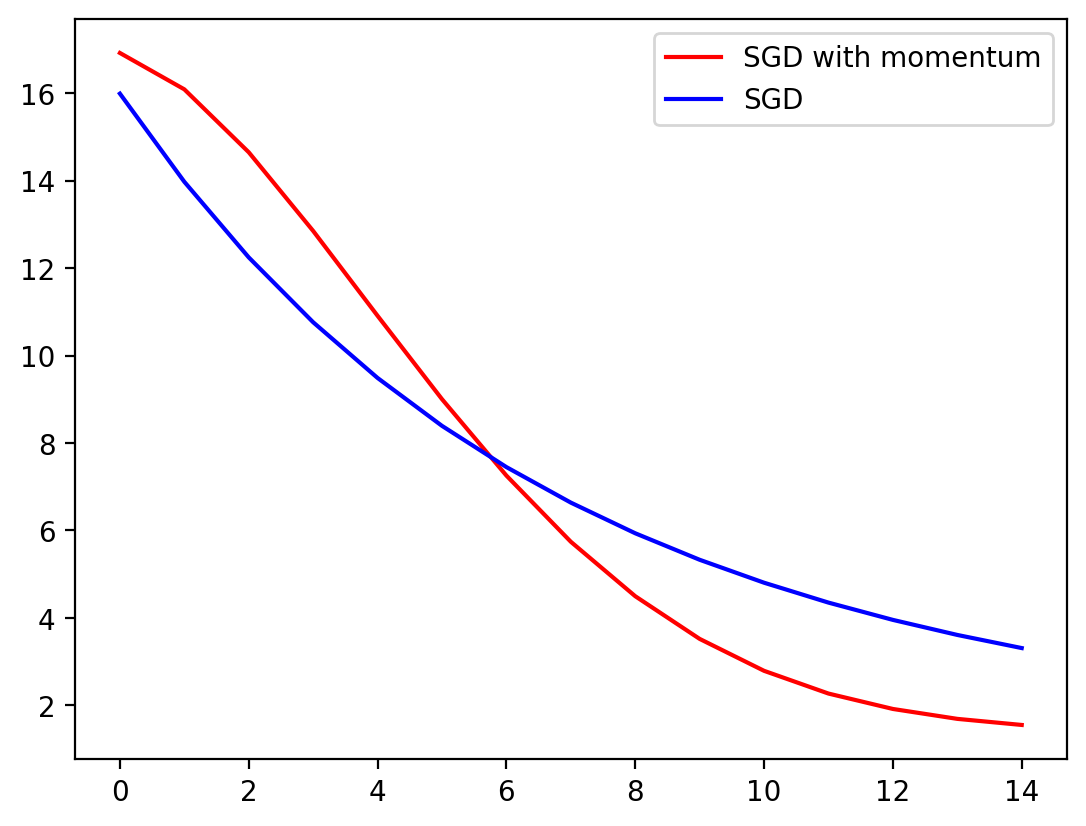

In [ ]:
plt.plot(momentum_stochastic_loss[:15], color='r', label='SGD with momentum')
plt.plot(stochastic_loss[:15], color='b', label='SGD')
plt.legend()
plt.show()

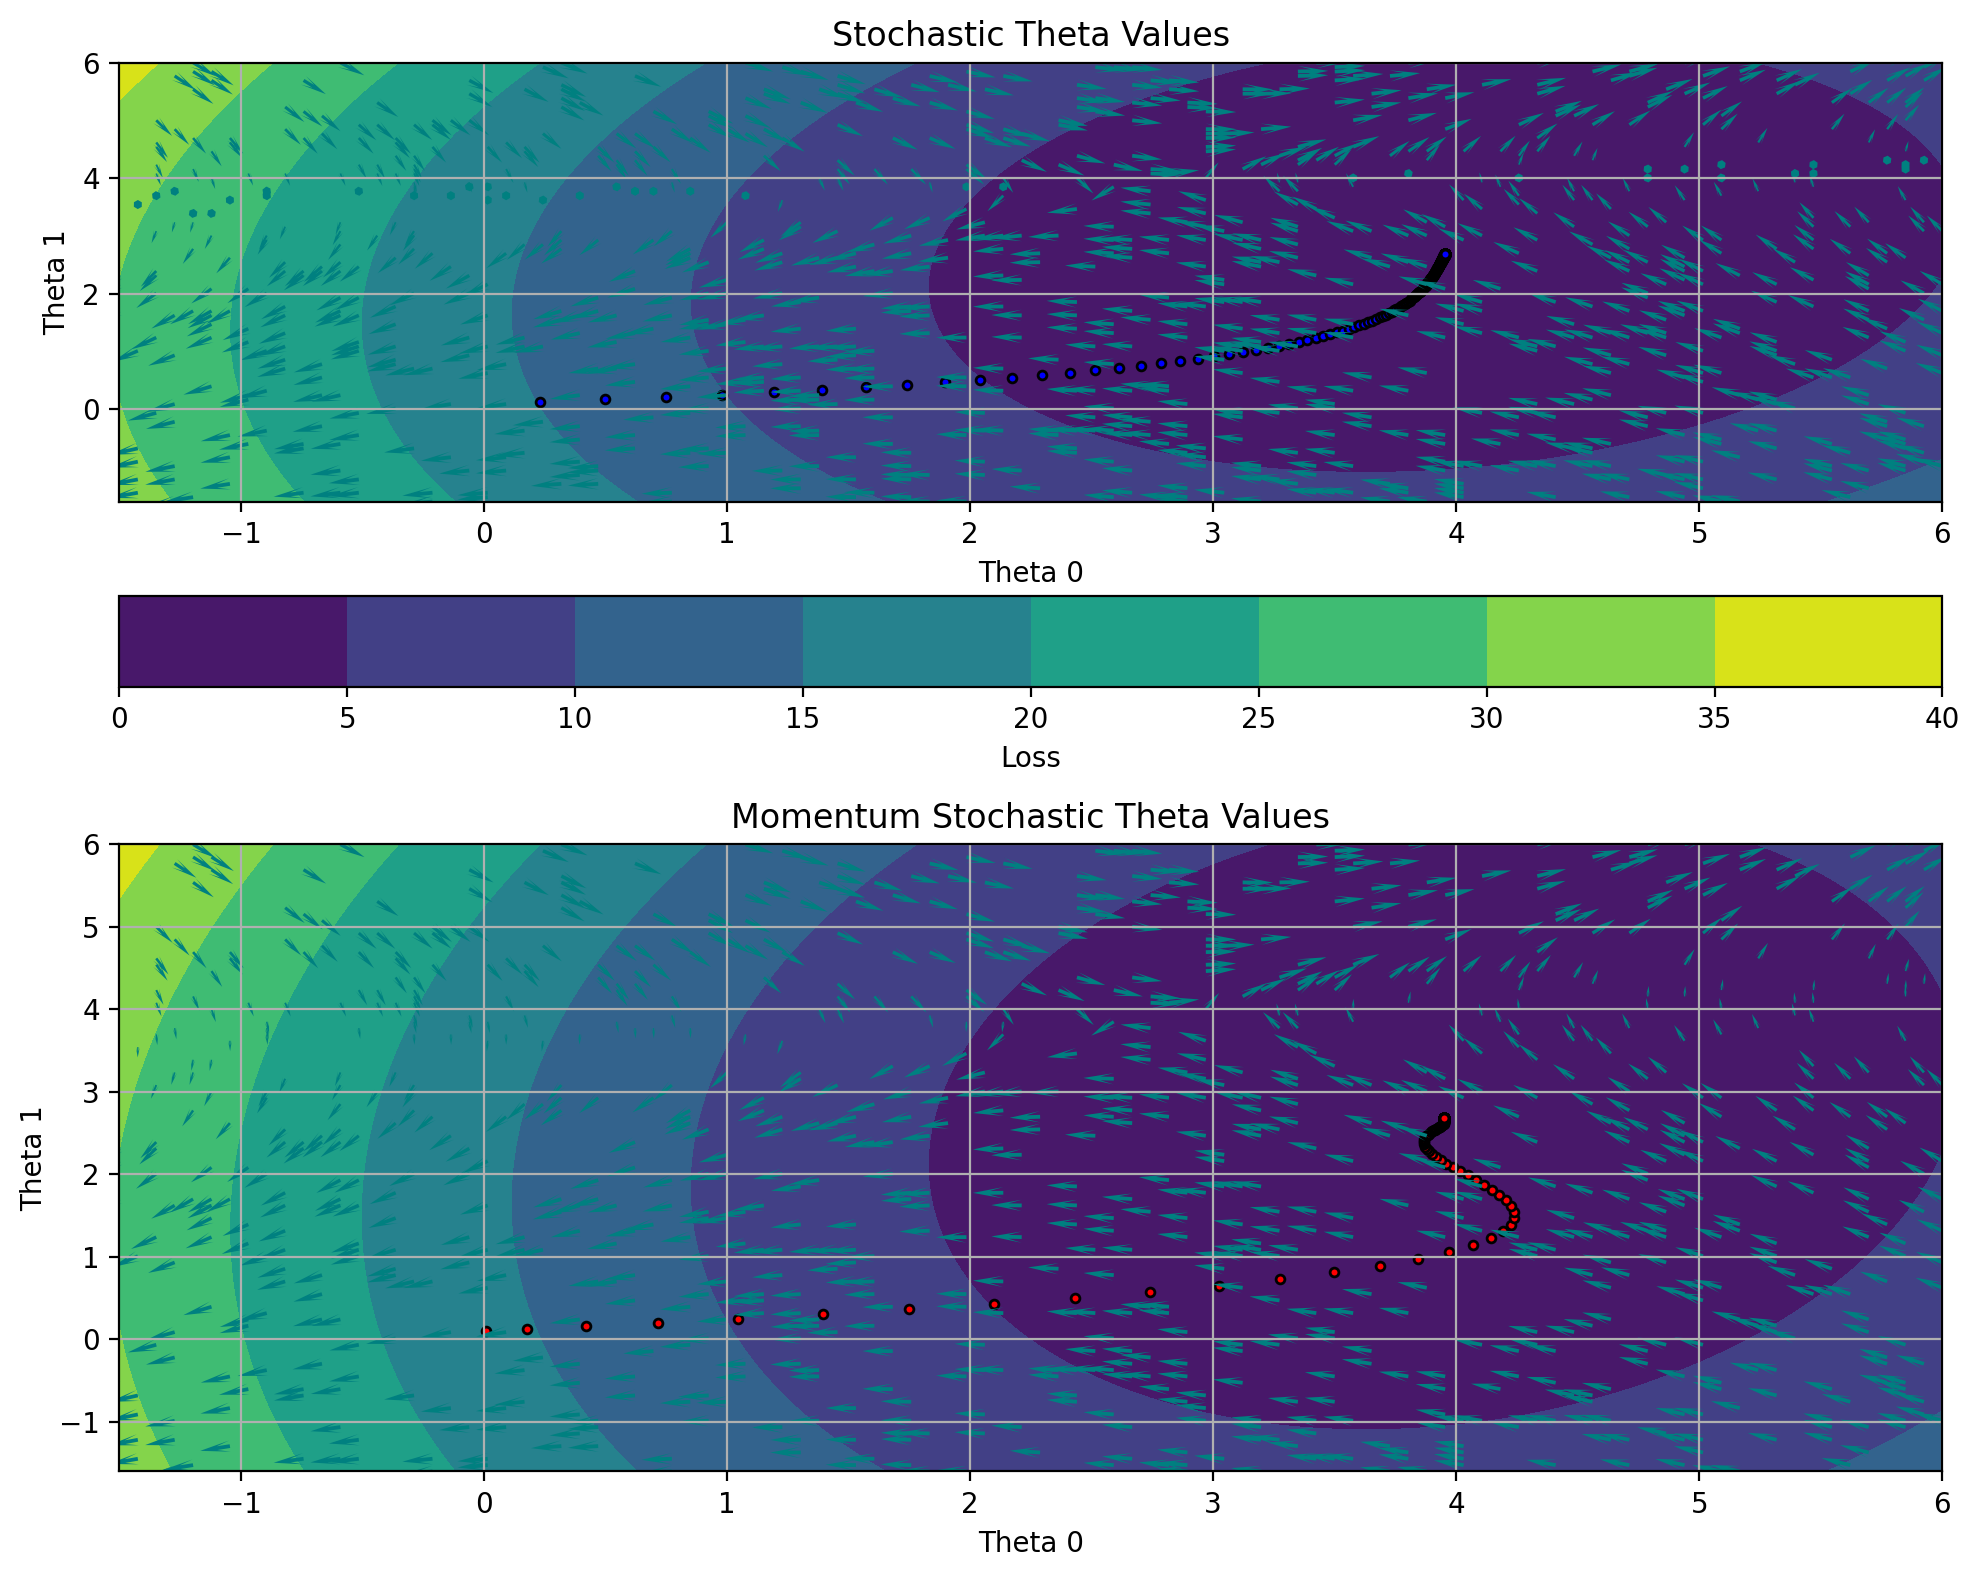

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

contour1 = axs[0].contourf(theta_0_range, theta_1_range, grid_loss.T, s=50, cmap='viridis')

axs[0].scatter(stochastic_theta_0_values, stochastic_theta_1_values, color='blue',
               edgecolor='black', s=10)
axs[0].quiver(X_subsampled, Y_subsampled, U_normalized, V_normalized,
           color='teal', headlength=8, scale=8, scale_units='xy', width=0.005)

axs[0].set_title('Stochastic Theta Values')
axs[0].set_xlabel('Theta 0')
axs[0].set_ylabel('Theta 1')
axs[0].grid(True)

contour2 = axs[1].contourf(theta_0_range, theta_1_range, grid_loss.T, s=50, cmap='viridis')

axs[1].scatter(momentum_stochastic_theta_0_values, momentum_stochastic_theta_1_values, color='red',
               edgecolor='black', s=10)
axs[1].quiver(X_subsampled, Y_subsampled, U_normalized, V_normalized,
           color='Teal', headlength=8, scale=8, scale_units='xy', width=0.005)

axs[1].set_title('Momentum Stochastic Theta Values')
axs[1].set_xlabel('Theta 0')
axs[1].set_ylabel('Theta 1')
axs[1].grid(True)

fig.colorbar(contour1, orientation='horizontal', label='Loss')

plt.tight_layout()
plt.show()


## Task 5

You have an image patch of size (50x50) that you want to compress using matrix factorization. To do this, you'll split the patch $[N\times N]$ into two smaller matrices of size $[N\times r]$ and $[r\times N]$ using matrix factorization. Compute the compressed patch by multiplying these two matrices and compare the reconstructed image patch with the original patch. Compute the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed image patches.

- Test different values for the low-rank $r = [5, 10, 25, 50]$.
- Use Gradient Descent to learn the compressed matrices.
- Display the reconstructed image patches, keeping the original pixel values outside the patch unchanged, and use your compressed matrix for the patch to show how well the reconstruction works.
- Compute the RMSE and PSNR for each value of $r$.

Here is a reference set of patches that you can choose. You can chose an image of your liking and create patches. You can choose the image shown below as well. **[3 Marks]**

<div style="display: flex;">
  <img src="sample_images/1colour.jpg" alt="Image 1" width="250"/>
  <img src="sample_images/2-3_colours.jpg" alt="Image 2" width="270"/>
  <img src="sample_images/multiple_colours.jpg" alt="Image 3" width="265"/>
</div>

<br>

torch.Size([3, 360, 540])
torch.Size([360, 540])


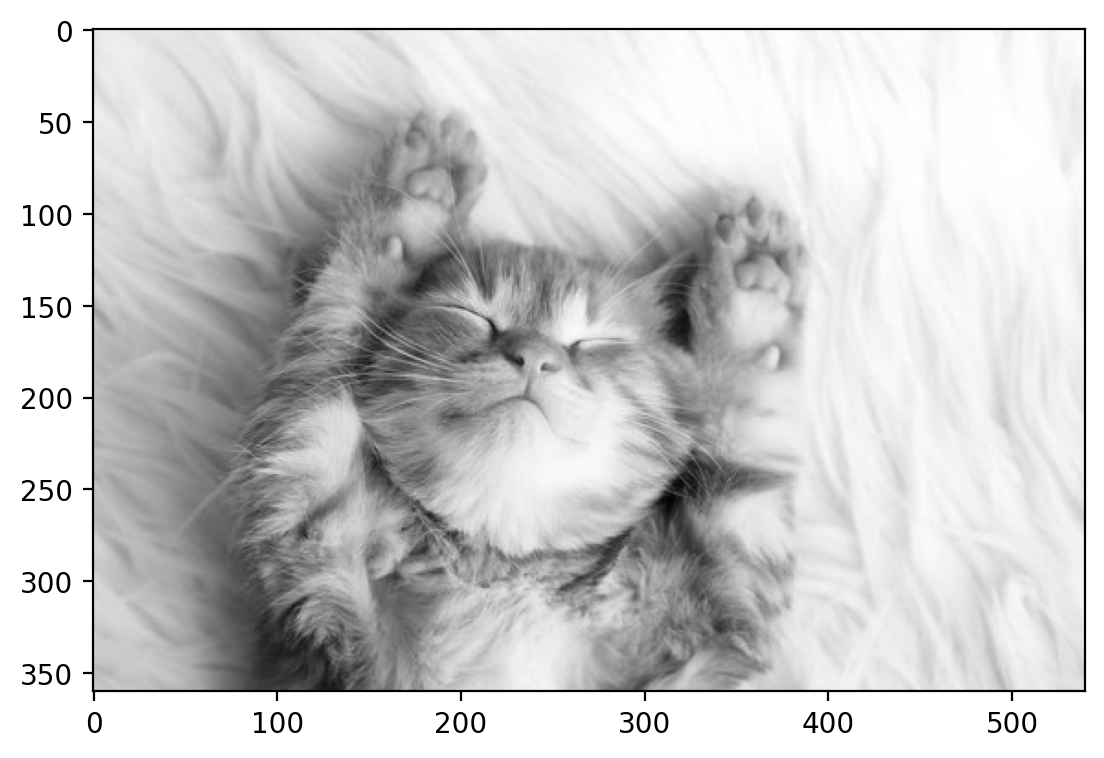

In [ ]:
img = torchvision.io.read_image("./sample_images/cat.jpg")
print(img.shape)

img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

plt.imshow(img, cmap='gray')

In [ ]:
img = img/225

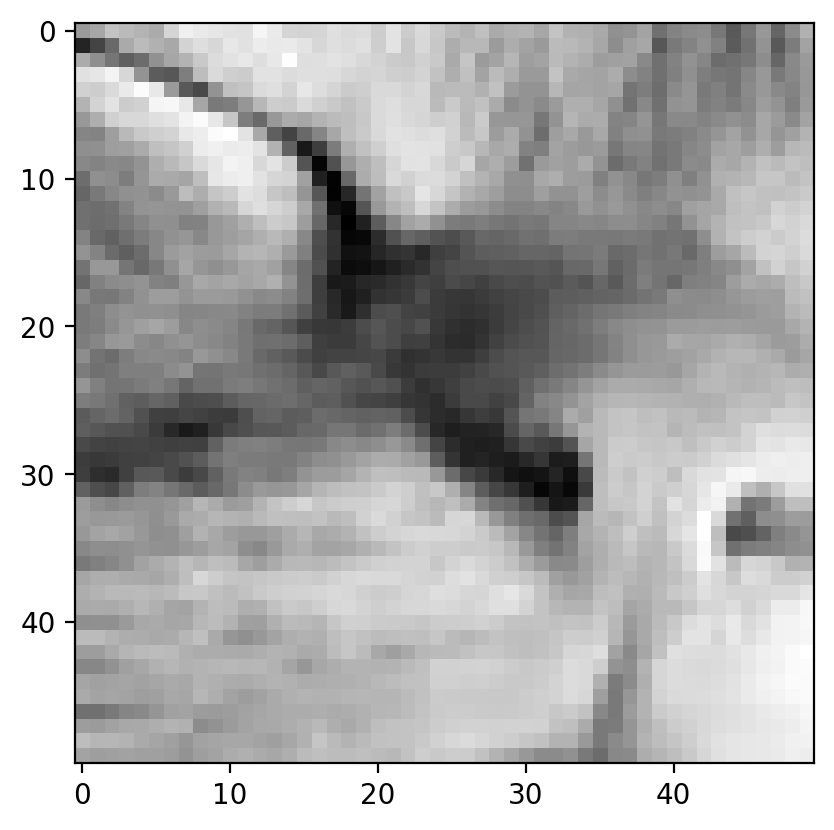

In [ ]:
top = 150
bottom = 200
left = 200
right = 250

plt.imshow(img[top:bottom,left:right], cmap='gray')
img_patch = img[top:bottom,left:right]

In [ ]:
N = 50
r = 10

A = torch.randn((N, r), requires_grad=True)
B = torch.randn((r, N), requires_grad=True)

optimizer = Adam([A,B], lr=0.01)

with torch.no_grad():

    loss = torch.norm(img_patch - torch.mm(A, B))

print(loss.item())

161.8530731201172


In [ ]:
def get_Z(img_patch, N, r):

    A = torch.randn((N, r), requires_grad=True)
    B = torch.randn((r, N), requires_grad=True)

    optimizer = Adam([A,B], lr=0.01)

    for epoch in range(10000):

        loss = torch.norm(img_patch - torch.mm(A, B))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        #if epoch%1000 == 0:
        #    print(f"Epochs {epoch} --> loss: {loss.item()}")

    return torch.mm(A, B).detach()

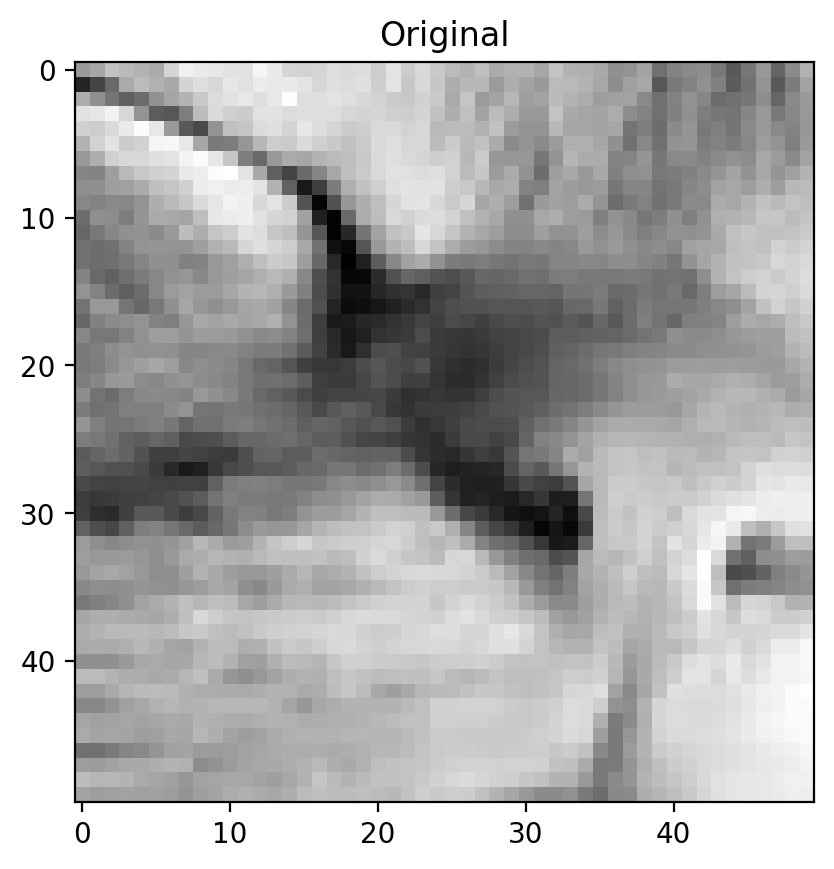

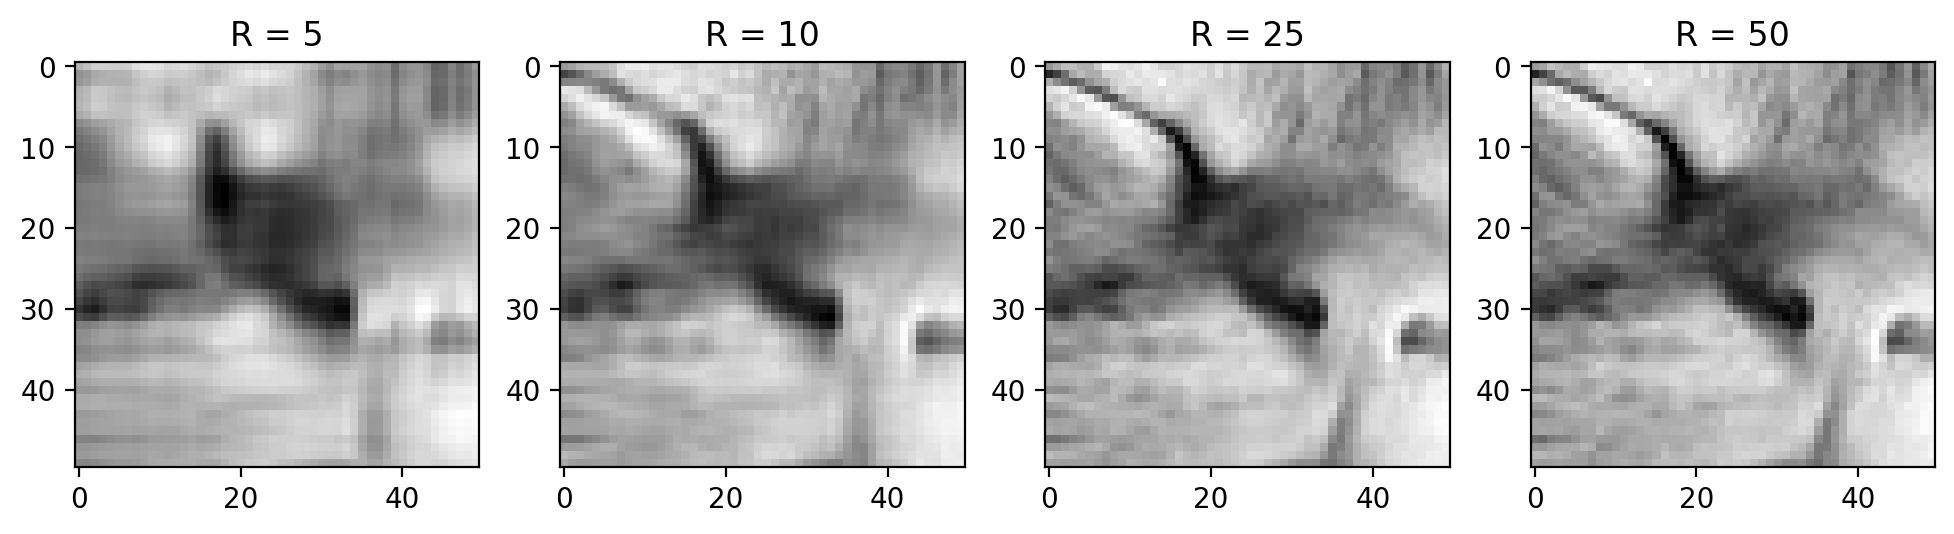

In [ ]:
plt.imshow(img_patch, cmap='gray')
plt.title("Original")

fig, ax = plt.subplots(1,4, figsize=(12,12))

R = [5, 10, 25 ,50]
Z_r = []

for idx, r in enumerate(R):

    Z = get_Z(img_patch, 50, r)

    Z_r.append(Z)
    ax[idx].imshow(Z, cmap='gray')
    ax[idx].set_title(f"R = {r}")

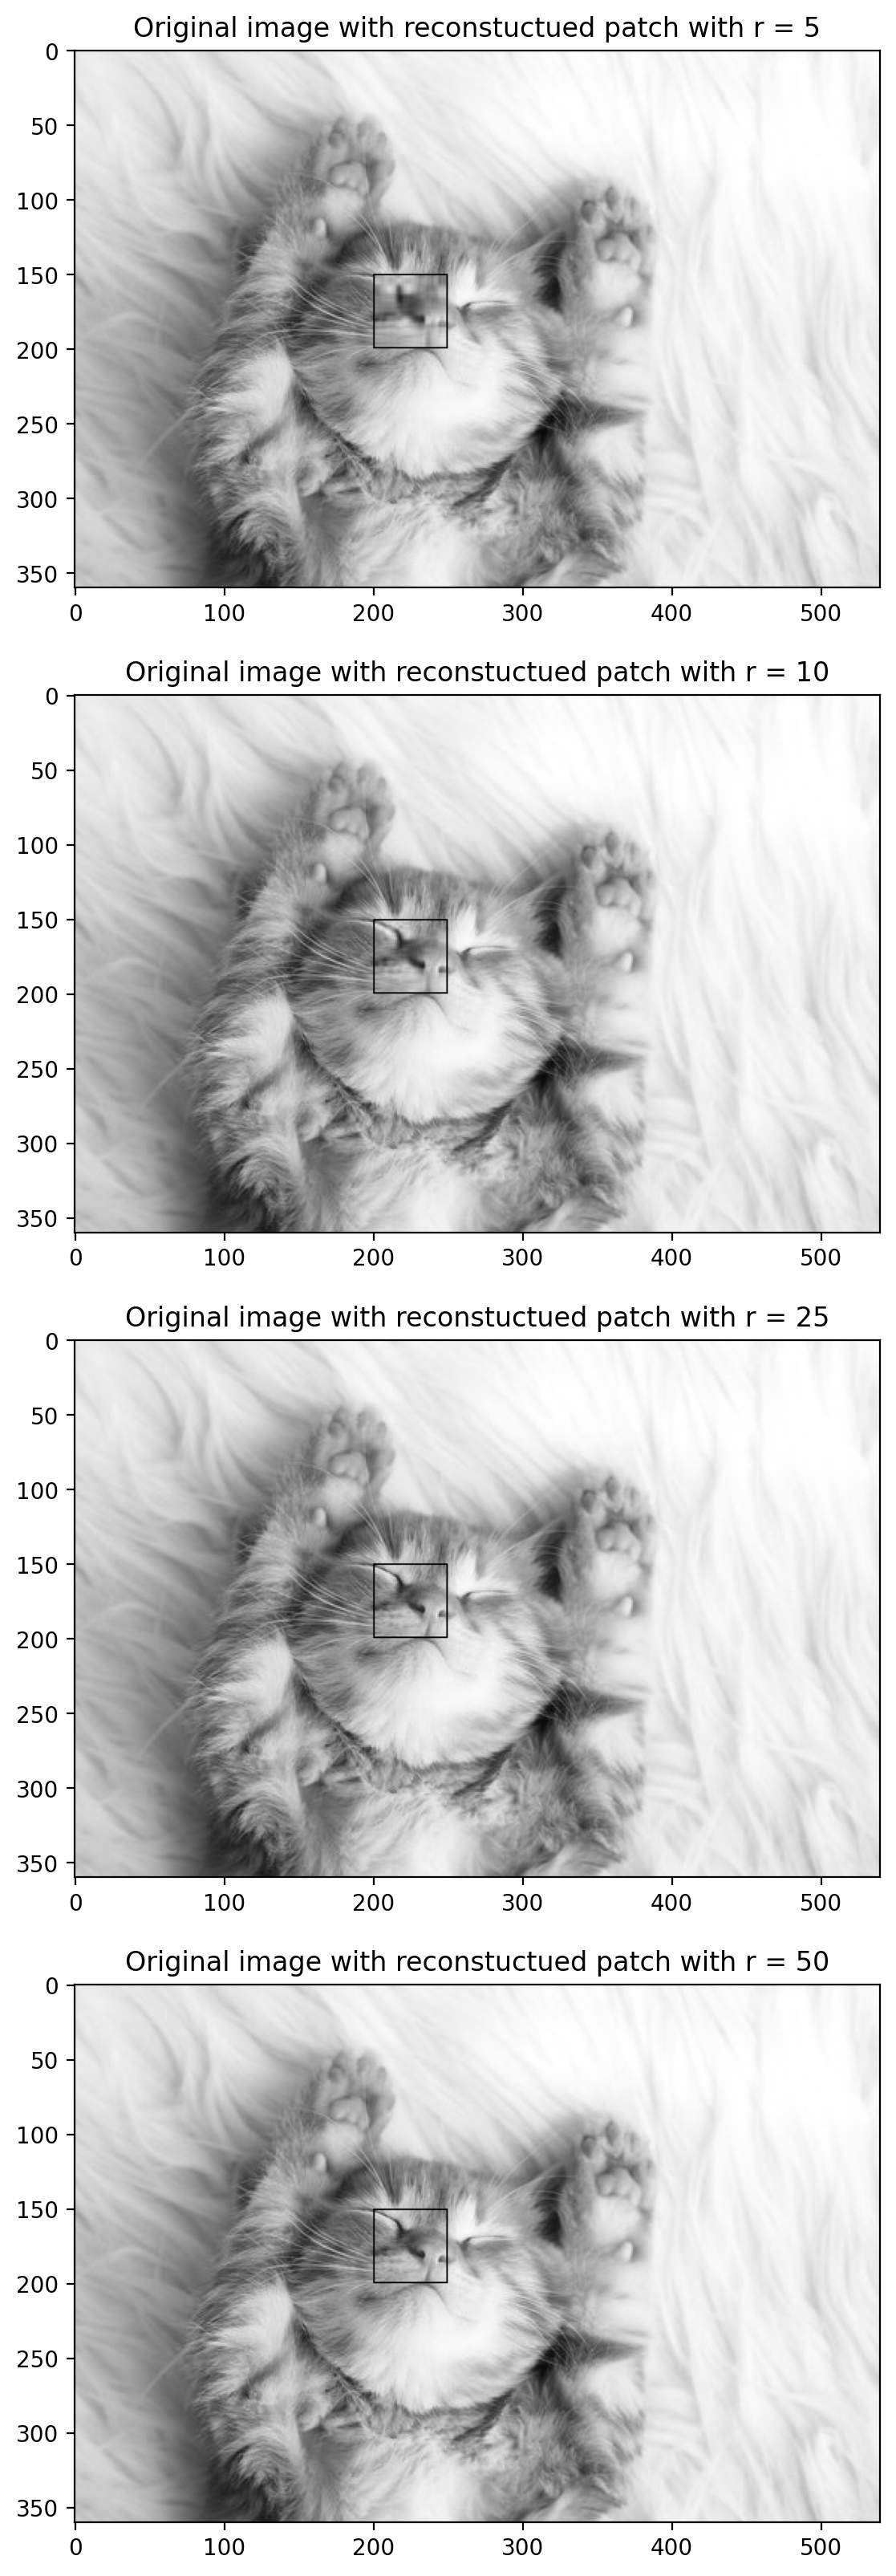

In [ ]:
img1 = img.clone()

fig, ax = plt.subplots(4,1,figsize=(20,20))

for idx, r in enumerate(R):
    img1[top:bottom,left:right] = Z_r[idx]

    boundary_value = 0
    img1[top:bottom, left:left+1] = boundary_value
    img1[top:bottom, right-1:right] = boundary_value
    img1[top:top+1, left:right] = boundary_value
    img1[bottom-1:bottom, left:right] = boundary_value

    ax[idx].imshow(img1, cmap='gray')
    ax[idx].set_title(f"Original image with reconstuctued patch with r = {r}")

MSE Loss

In [ ]:
loss = torch.nn.MSELoss()

for idx, r in enumerate(R):
    print(f"R: {r} Loss: {torch.sqrt(loss(img_patch, Z_r[idx]))}")

R: 5 Loss: 0.0635020062327385
R: 10 Loss: 0.032244324684143066
R: 25 Loss: 0.008851338177919388
R: 50 Loss: 0.00657586008310318


PSNR

In [ ]:
def PSNR(original_img, reconstructed_img, max_pixel_value=1.0):

    mse = loss(original_img, reconstructed_img)

    psnr = 10 * torch.log10((max(original_img.flatten()) ** 2) / mse)

    return psnr

for idx, r in enumerate(R):
    print(f"R: {r} Loss: {PSNR(img_patch, Z_r[idx])}")

R: 5 Loss: 24.147735595703125
R: 10 Loss: 30.034420013427734
R: 25 Loss: 41.263309478759766
R: 50 Loss: 43.84443283081055


# Task 3
Begin by exploring the instructor's notebook that introduces the application of Random Fourier Features (RFF) for image reconstruction. Demonstrate the following applications using the cropped image from the notebook:

Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) [3 Marks]

The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics: [1 Marks]

RMSE on predicted v/s ground truth high resolution image
Peak SNR on predicted v/s ground truth high resolution image
Follow the below steps to execute this task:

Start with a 400x400 high-resolution image (the original image).
Resize it to a 200x200 image (this will be your input image). You can use OpenCV's resize function or another library for this. Here’s a tutorial to help: OpenCV Resize Image Tutorial.
Use Random Fourier Features (RFF) along with linear regression to learn a function based on the 200x200 image.
Use the learned function to predict the pixel values for the 400x400 image. This means predicting the values for the pixels that fall between the existing pixels of the 200x200 image.
Compare your predicted 400x400 image with the original 400x400 high-resolution image.
Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the predicted image and the original high-resolution image.


# Approach1

In [ ]:


import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


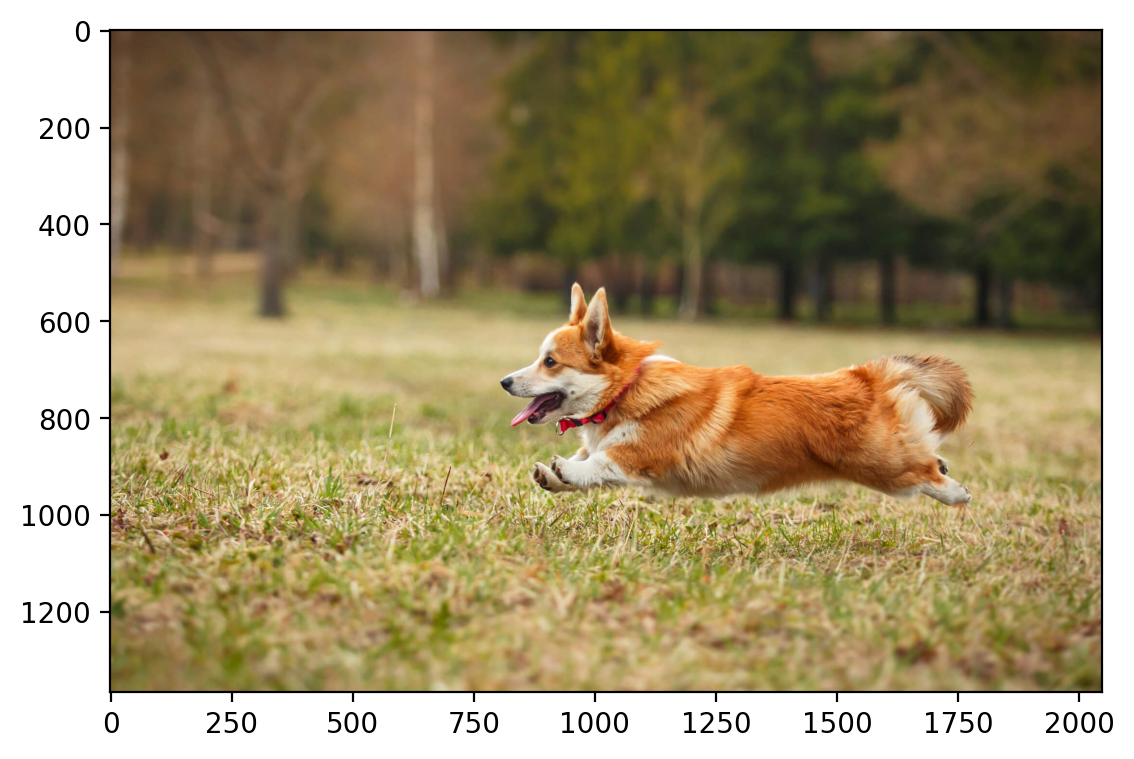

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [ ]:
import cv2
# Resize the image to 200x200
resized_image = cv2.resize(rearrange(img, 'c h w -> h w c').numpy(), (200, 200)) # Changed line: convert the image to a NumPy array before resizing and change the order of dimensions

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

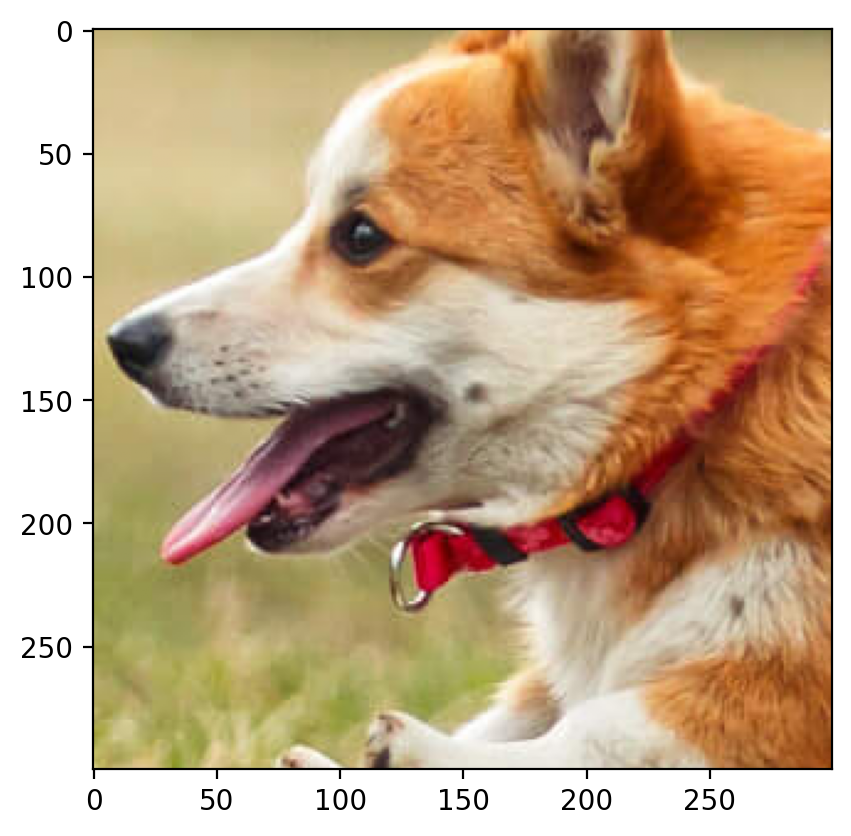

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [ ]:
import cv2
# Resize the image to 200x200
resized_image = cv2.resize(rearrange(crop, 'c h w -> h w c').numpy(), (200, 200))


In [ ]:
resized_image_1=torch.tensor(resized_image)
resized_image_1 = resized_image_1.to(device)

In [ ]:
# Get the dimensions of the image tensor
num_channels, height, width = resized_image_1.shape
print(num_channels, height, width)

200 200 3


In [ ]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
dog_X, dog_Y = create_coordinate_map(resized_image_1.reshape(3,200,200))

dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [ ]:
X_rff = create_rff_features(dog_X_scaled, 40000, 0.008)
X_rff.shape

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
dog_X_scaled.shape

In [ ]:
train(net, 0.01, X_rff, dog_Y, 10000)

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        outputs = outputs.permute(2, 0, 1)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu())
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
plot_reconstructed_and_original_image(resized_image_1, net, X_rff, title="Reconstructed Image")


# Approach2

In [2]:
from PIL import Image


image_path = '/content/dog.jpg'
img = Image.open(image_path)

# Define the crop area: (left, upper, right, lower)

left = 800
upper = 600
right = left + 300
lower = upper + 300


cropped_img = img.crop((left, upper, right, lower))

cropped_image_path = '/content/cropped_dog.jpg'
cropped_img.save(cropped_image_path)

cropped_image_path

'/content/cropped_dog.jpg'

In [3]:
import cv2

# Load Image
image_path = '/content/cropped_dog.jpg'
image = cv2.imread(image_path)

# Resize
resized_image = cv2.resize(image, (200, 200))

resized_image_path = '/content/resized_dog_200x200.jpg'
cv2.imwrite(resized_image_path, resized_image)

resized_image_path


'/content/resized_dog_200x200.jpg'

In [4]:
import numpy as np
from PIL import Image
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

# original 200x200 image
image = Image.open('/content/resized_dog_200x200.jpg').convert('L')  #  grayscale conversion
image = np.array(image) / 255.0  # Normalization of pixel values between 0 and 1


height, width = image.shape
X = np.array([[i, j] for i in range(height) for j in range(width)])  # Original pixel positions
y = image.flatten()  # Flattened pixel values

# Random Fourier Features
rff = RBFSampler(gamma=0.1, n_components=5000)  # n_components = number of random features
X_transformed = rff.fit_transform(X)

# linear regression model using RFF features
ridge = Ridge(alpha=0.1)
ridge.fit(X_transformed, y)


#  new grid for the 400x400 image
new_height, new_width = 400, 400
X_new = np.array([[i * (height-1)/(new_height-1), j * (width-1)/(new_width-1)] for i in range(new_height) for j in range(new_width)])

#  400x400 coordinates Transformation using RFF
X_new_transformed = rff.transform(X_new)


y_pred = ridge.predict(X_new_transformed)

# Reshape into a 400x400 image
reconstructed_image = y_pred.reshape((new_height, new_width))

reconstructed_image = (reconstructed_image * 255).astype(np.uint8)  # Scale back to [0, 255]
Image.fromarray(reconstructed_image).save('reconstructed_400x400_image.jpg')

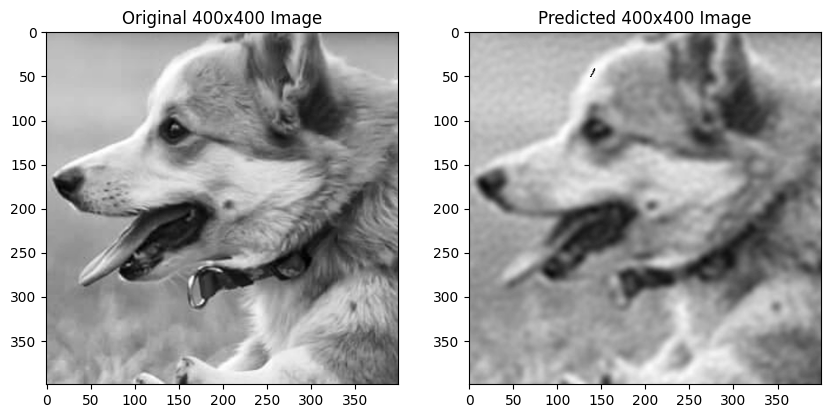

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

predicted_image = Image.open('reconstructed_400x400_image.jpg').convert('L')
predicted_image = predicted_image.resize((400, 400))  # Ensure it's 400x400
predicted_image = np.array(predicted_image)

original_image = Image.open('/content/cropped_dog.jpg').convert('L')
original_image = original_image.resize((400, 400))  # Ensure it's 400x400
original_image = np.array(original_image)


plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original 400x400 Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_image, cmap='gray')
plt.title('Predicted 400x400 Image')

plt.show()


In [6]:
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error
import math

predicted_image = Image.open('reconstructed_400x400_image.jpg').convert('L')
predicted_image = predicted_image.resize((400, 400))
predicted_image = np.array(predicted_image)

original_image = Image.open('/content/cropped_dog.jpg').convert('L')
original_image = original_image.resize((400, 400))
original_image = np.array(original_image)

# RMSE
rmse = np.sqrt(mean_squared_error(original_image, predicted_image))

# PSNR
max_pixel_value = 255.0  # Max pixel value for an 8-bit image
psnr = 20 * math.log10((max(original_image.flatten())) / rmse)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr} dB")

RMSE: 6.451443152504718
PSNR: 31.937666112676105 dB


# Task 2 : Reconstructing using Random Fourier Features (RFF) [3 marks]


Q1: Image Reconstruction - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (XY) to the pixel colors (RGB) Here, (XY) represents the coordinates of the pixels, and (RGB) represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images. [1.5 Mark]

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

# Read in a image from torchvision
img = torchvision.io.read_image("bird.jpg")
print(img.shape)

In [ ]:
from einops import rearrange
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled

In [ ]:
# Get the dimensions of the image tensor
num_channels, height, width = img_scaled.shape
print(num_channels, height, width)

In [ ]:


def create_coordinate_map(img):


    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()



    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
bird_X,bird_Y = create_coordinate_map(img_scaled)

bird_X.shape,bird_Y.shape

In [ ]:

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(bird_X)

# Scale the X coordinates
bird_X_scaled = scaler_X.transform(bird_X)

# Move the scaled X coordinates to the GPU
bird_X_scaled = torch.tensor(bird_X_scaled)

# Set to dtype float32
bird_X_scaled = bird_X_scaled.float()

In [ ]:

bird_X_scaled.shape

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
net = LinearModel(2, 3)

In [ ]:

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
train(net, 0.01, bird_X_scaled,bird_Y, 1000)

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
plot_reconstructed_and_original_image(img_scaled, net, bird_X_scaled, title="Reconstructed Image")


In [ ]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)

In [ ]:
X_rff = create_rff_features(bird_X_scaled, 7500, 0.008)

In [ ]:
X_rff.shape

In [ ]:
net = LinearModel(X_rff.shape[1], 3)

train(net, 0.005, X_rff, bird_Y, 1000)

In [ ]:
plot_reconstructed_and_original_image(img_scaled, net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:
def calculate_rmse(img1, img2):
    # Ensure both images are in float32 for numerical stability
    img1 = img1.float()
    img2 = img2.float()

    # Calculate the Mean Squared Error (MSE)
    mse = torch.mean((img1 - img2) ** 2)

    # RMSE is the square root of MSE
    rmse = torch.sqrt(mse)
    return rmse.item()
import math
def calculate_psnr(img1, img2):
    rmse = calculate_rmse(img1, img2)
    if rmse == 0:
        return float('inf')  # No error means infinite PSNR

    max_pixel_value = 255.0  # For 8-bit images
    psnr = 20 * math.log10(max_pixel_value / rmse)
    return psnr

In [ ]:
X_rff.shape

In [ ]:
img_scaled_flat = img_scaled.view(-1)  # Flattened shape will be (3 * 256 * 256 = 196608)


In [ ]:
X_rff_subset = X_rff.view(-1)[:img_scaled_flat.numel()]  # Take the first 196608 elements


In [ ]:
# Ensure both tensors are of the same shape
print(f"Shape of img_scaled_flat: {img_scaled_flat.shape}")
print(f"Shape of X_rff_subset: {X_rff_subset.shape}")

# Now calculate RMSE
rmse_value = calculate_rmse(img_scaled_flat, X_rff_subset)
print(f"RMSE for rrf features: {rmse_value}")


In [ ]:
pnsrrrf=calculate_psnr(img_scaled_flat, X_rff_subset)
print(f"PSNR for rrf features: {pnsrrrf}")

Q2: Audio Reconstruction - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time () to amplitude (A), where t is the time point, and A is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction. [1.5 Mark]

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
from IPython.display import Audio
Audio('sound.mp3')

In [ ]:

import torchaudio
audio, sr = torchaudio.load('./sound.mp3')

In [ ]:
sr

In [ ]:

print(audio.shape)
audio = audio[0]

In [ ]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

In [ ]:

audio

In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

In [ ]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [ ]:
audio = audio[-2 * sr:]
print(audio.shape)
print(audio)

In [ ]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

In [ ]:
Audio(audio, rate = sr)

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [ ]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

In [ ]:

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

In [ ]:

import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [ ]:
print(pred_audio)
print(audio)

In [ ]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)


In [ ]:
Audio(pred_audio, rate = sr)

In [ ]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

def calculate_snr(original, reconstructed):
    signal_power = np.mean(original ** 2)
    noise = original - reconstructed
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / noise_power)

In [ ]:
calculate_rmse(audio.numpy(), pred_audio)

In [ ]:
calculate_snr(audio.numpy(), pred_audio)

### Task 4 : Image Reconstruction using Matrix Factorisation [4 Marks]
Use the instructor's notebook on matrix factorisation, and solve the following questions. Here, ground truth pixel values are missing for particular regions within the image- you don't have access to them.



1. Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank 
r
. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics. [1 Marks]

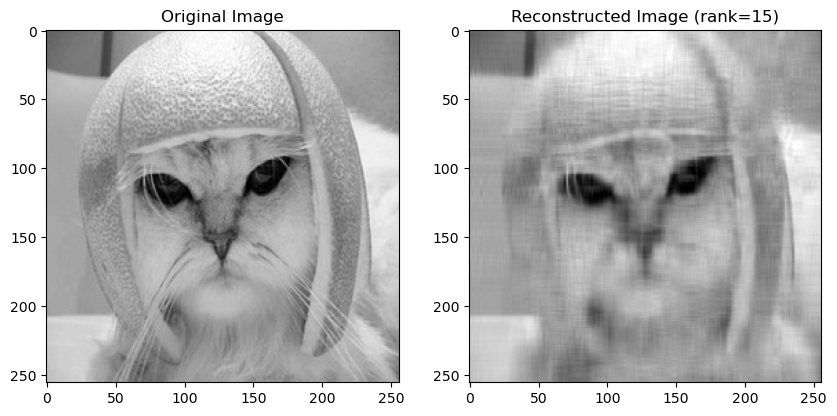

RMSE: 0.0417
PSNR: 27.5936


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# Load the image (make sure the image is normalized between 0 and 1)
image = img_as_float(io.imread('cat.jpg', as_gray=True))  # Grayscale image

# Matrix Factorization function using Gradient Descent
def matrix_factorization(image, r, lr=0.001, max_iters=1000, tol=1e-5):
    m, n = image.shape
    U = np.random.rand(m, r)
    V = np.random.rand(r, n)

    for iteration in range(max_iters):
        # Compute the current reconstruction error
        error = image - np.dot(U, V)
        
        # Gradient descent step
        U_gradient = -2 * np.dot(error, V.T)
        V_gradient = -2 * np.dot(U.T, error)
        U -= lr * U_gradient
        V -= lr * V_gradient

        # Convergence check
        if np.linalg.norm(error) < tol:
            break

    return U, V, iteration

# Reconstruction
rank = 15  # Set the rank for factorization
U, V, iters = matrix_factorization(image, rank)
reconstructed_image = np.dot(U, V)

# Clip the values of the reconstructed image to stay in the range [0, 1]
reconstructed_image = np.clip(reconstructed_image, 0, 1)

# RMSE and PSNR calculation
rmse = np.sqrt(mean_squared_error(image, reconstructed_image))
psnr = peak_signal_noise_ratio(image, reconstructed_image)

# Plot original and reconstructed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title(f'Reconstructed Image (rank={rank})')
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

print(f'RMSE: {rmse:.4f}')
print(f'PSNR: {psnr:.4f}')


2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.[3 Marks]

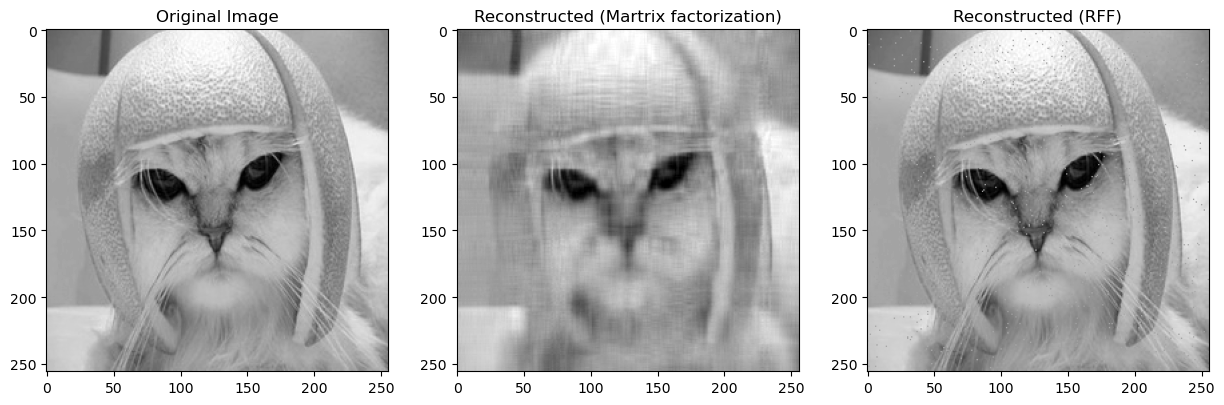

Matrix Factorization - RMSE: 0.0417, PSNR: 27.6034
RFF - RMSE: 0.0172, PSNR: 35.3013


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression

# Load the image (normalized between 0 and 1)
image = img_as_float(io.imread('cat.jpg', as_gray=True))  # Grayscale image

# Introduce missing pixels by setting them to NaN
missing_image = image.copy()
missing_indices = np.random.choice(np.arange(image.size), size=900, replace=False)  # Randomly remove 900 pixels
missing_image.ravel()[missing_indices] = np.nan

# Mask for missing pixels
mask = np.isnan(missing_image)

### Matrix Factorization for Image Reconstruction ###
def matrix_factorization_missing(image, mask, r, lr=0.001, max_iters=1000, tol=1e-5):
    m, n = image.shape
    U = np.random.rand(m, r)
    V = np.random.rand(r, n)

    for iteration in range(max_iters):
        # Only calculate the error for non-missing pixels
        error = np.nan_to_num(image) - np.dot(U, V)
        error[mask] = 0
        U_gradient = -2 * np.dot(error, V.T)
        V_gradient = -2 * np.dot(U.T, error)
        U -= lr * U_gradient
        V -= lr * V_gradient

        # Convergence check
        if np.linalg.norm(error) < tol:
            break

    return U, V

# Reconstruction with Matrix Factorization
rank = 17  # You can change rank based on the dataset
U_mf, V_mf = matrix_factorization_missing(missing_image, mask, rank)
reconstructed_mf = np.dot(U_mf, V_mf)
reconstructed_mf = np.clip(reconstructed_mf, 0, 1)

# RMSE and PSNR for matrix factorization reconstruction
rmse_mf = np.sqrt(mean_squared_error(image, reconstructed_mf))
psnr_mf = peak_signal_noise_ratio(image, reconstructed_mf)


### Random Fourier Features (RFF) and Linear Regression for Image Reconstruction ###
def rff_reconstruction(image, missing_indices, rbf_components=500):
    h, w = image.shape
    X = np.column_stack(np.unravel_index(np.arange(h*w), (h, w)))  # Pixel coordinates
    y = image.ravel()

    # Remove missing pixels for training
    X_train = np.delete(X, missing_indices, axis=0)
    y_train = np.delete(y, missing_indices)

    # RFF transformation and linear regression
    rbf_feature = RBFSampler(gamma=1, n_components=rbf_components, random_state=1)
    X_features = rbf_feature.fit_transform(X_train)
    model = LinearRegression().fit(X_features, y_train)

    # Predict the missing pixels
    X_missing = X[missing_indices]
    X_missing_features = rbf_feature.transform(X_missing)
    predicted_pixels = model.predict(X_missing_features)

    # Reconstruct the image
    reconstructed_image = image.copy()
    reconstructed_image.ravel()[missing_indices] = predicted_pixels
    return reconstructed_image

# Reconstruct the image using RFF + Linear Regression
reconstructed_rff = rff_reconstruction(missing_image, missing_indices)
reconstructed_rff = np.clip(reconstructed_rff, 0, 1)

# RMSE and PSNR for RFF reconstruction
rmse_rff = np.sqrt(mean_squared_error(image, reconstructed_rff))
psnr_rff = peak_signal_noise_ratio(image, reconstructed_rff)


### Plotting the Results ###
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Reconstructed (Martrix factorization)')
plt.imshow(reconstructed_mf, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Reconstructed (RFF)')
plt.imshow(reconstructed_rff, cmap='gray')

plt.show()

# Print out the RMSE and PSNR values for both methods
print(f'Matrix Factorization - RMSE: {rmse_mf:.4f}, PSNR: {psnr_mf:.4f}')
print(f'RFF - RMSE: {rmse_rff:.4f}, PSNR: {psnr_rff:.4f}')
